In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Make division default to floating-point, saving confusion
from __future__ import division
from __future__ import print_function

# Allowed libraries
import numpy as np
import pandas as pd
import scipy as sp
import heapq as pq
import matplotlib as mp
import math
import datetime
from itertools import product, combinations
from collections import OrderedDict as odict
from graphviz import Digraph
from tabulate import tabulate

### Helpers

In [3]:
def printFactor(f):
    """
    argument 
        `f`, a factor to print on screen
    """
    table = list()
    for key, item in f['table'].items():
        k = list(key)
        k.append(item)
        table.append(k)
    dom = list(f['dom'])
    dom.append('Pr')
    print(tabulate(table,headers=dom,tablefmt='orgtbl'))
    
def factor_to_csv(f):
    """
    argument
    `f`, a factor to save to a csv file.
    The first row of the csv file will be the variables; followed by the factor
    """
    cols = list(f['dom'])
    cols.append('')
    O = f['table']
    A = np.zeros((len(O), len(cols)))
    for i, (key, val) in enumerate(O.items()):
        A[i] = [*key, val]
    df = pd.DataFrame(A, columns=cols)
    df.to_csv('_'.join(cols)+'.csv', index=False, header=True)
    
def csv_to_factor(filename):
    """
    argument
    `filename`, a csv file to convert to a factor
    The first row of the csv file contains the columns headers, followed by the data
    """
    f = {'dom':None, 'table':odict([])}
    with open(filename, "r") as file:
        for i, line in enumerate(file):
            line = line.strip()
            L = line.split(',')
            L = [v for v in L if v]
            if i == 0: #header
                f['dom'] = tuple(L)
            else: #data
                L = [float(v) for v in L]
                f['table'][tuple(L[:-1])] = L[-1]
    return f

def convert_observation(obs):
    """
    arguments
        obs: dictionary of sensors to their oberserved value
    returns
        new dictionary, with observed values mapped to 0/1
    """
    new_obs = obs.copy()
    for E in obs.keys():
        if E[:5] == 'relia' or E[:5] == 'unrel':
            if obs[E] == 'motion':
                new_obs[E] = 1
            elif obs[E] == 'no motion':
                new_obs[E] = 0
            else:
                new_obs[E] = None
        elif E[:5] == 'door_':
            if obs[E] != 0:
                new_obs[E] = 1
            elif obs[E] == 0:
                new_obs[E] = 0
            else:
                new_obs[E] = None
        elif E[:5] == 'robot':
            if obs[E] == None:
                new_obs[E] = None
            else:
                robot_obs = eval(obs[E])
                new_obs[E] = (robot_obs[0], 1) if robot_obs[1] > 0 else (robot_obs[0], 0)
        else:
            new_obs[E] = obs[E]
    return new_obs
            
obs = {'reliable_sensor1':'motion','reliable_sensor2':'no motion','reliable_sensor3':'motion',\
       'reliable_sensor4':'motion','unreliable_sensor1':None,'unreliable_sensor2':'motion',\
       'unreliable_sensor3':'motion','unreliable_sensor4':'motion','door_sensor1': -1,'door_sensor2': 0,\
       'door_sensor3': 0,'door_sensor4':5,'robot1': None,'robot2': "('r16', 0)",\
       'time': datetime.time(8, 0),'electricity_price': 0.81}
print(convert_observation(obs))

{'reliable_sensor1': 1, 'reliable_sensor2': 0, 'reliable_sensor3': 1, 'reliable_sensor4': 1, 'unreliable_sensor1': None, 'unreliable_sensor2': 1, 'unreliable_sensor3': 1, 'unreliable_sensor4': 1, 'door_sensor1': 1, 'door_sensor2': 0, 'door_sensor3': 0, 'door_sensor4': 1, 'robot1': None, 'robot2': ('r16', 0), 'time': datetime.time(8, 0), 'electricity_price': 0.81}


In [4]:
def smoothen(f):
    table = list()
    for row in f['table'].items():
        if row[1] == 0:
            table.append((row[0]), 0.0001)
        elif row[1] == 1:
            table.append((row[0]), 0.9999)
        else:
            raise Exception("Failed.")
    return {'dom': f['dom'], 'table':odict(table)}

def prob(factor, *entry):
    """
    argument 
        `factor`, a dictionary of domain and probability table,
        `entry`, a list of values, one for each variable, in the same order as specified in the factor domain.
    returns 
        p(entry)
    """
    return factor['table'][entry]    

def evidence(E, obs, outcomeSpace):
    """
    argument 
        `E`, variable.
        `e`, the observed value for E.
        `outcomeSpace`, dictionary with the domain of each variable
    returns
        newOutcomeSpace: new outcomeSpace with update made to E. 
    """
    newOutcomeSpace = outcomeSpace.copy()
    newOutcomeSpace[E] = (obs,)
    return newOutcomeSpace

def marginalize_room(f, var, outcomeSpace):
    """
    argument 
        `f`, factor to be marginalized.
        `var`, variable to be summed out.
        `outcomeSpace`, dictionary with the domain of each variable
    returns
        new factor f' with dom(f') = dom(f) - {var}
    assumes that the variable to be eliminated is at the front of the domain (asserted), and is binary
    """ 
    #"""
    new_dom = tuple(f['dom'][1:])
    #table = list()
    vars_to_keep = 2**(len(f['dom']) - 1)
    items = list(f['table'].items())
    #for i in range(vars_to_keep):
    #    entries = items[i][0][1:]
    #    table.append((entries, items[i][1] + items[i+vars_to_keep][1]))
    table = [(items[i][0][1:], items[i][1] + items[i + vars_to_keep][1]) for i in range(vars_to_keep)]
    return {'dom': new_dom, 'table': odict(table)}    

def marginalize_sensor(f, var, outcomeSpace):
    """
    argument 
        `f`, factor to be marginalized.
        `var`, variable to be summed out.
        `outcomeSpace`, dictionary with the domain of each variable
    returns
        new factor f' with dom(f') = dom(f) - {var}
    assumes that the variable to be eliminated is at the front of the domain (asserted), and is binary
    """ 
    new_dom = list(f['dom'])
    new_dom.remove(var)
    table = list()
    for entries in product(*[outcomeSpace[node] for node in new_dom]):
        s = 0;
        S = []
        for val in outcomeSpace[var]:
            entriesList = list(entries)
            entriesList.insert(f['dom'].index(var), val)
            p = prob(f, *entriesList)
            s = s + p
        table.append((entries, s))
    return {'dom': tuple(new_dom), 'table': odict(table)}
    
    
def normalize(f, outcomeSpace):
    """
    argument 
        `f`, factor to be normalized.
    returns
        new factor as a copy of f with entries that sum to 1, over the dependent variable
    """ 
    new_f = {}
    new_f['dom'] = f['dom']
    new_f['table'] = odict([])
    vars = f['dom'][:-1]
    for entries in product(*[outcomeSpace[V] for V in vars]):
        entries0, entries1 = tuple(list(entries) + [0]), tuple(list(entries) + [1])
        N = f['table'][entries0] + f['table'][entries1]
        new_f['table'][entries0] = f['table'][entries0] / N
        new_f['table'][entries1] = f['table'][entries1] / N
    return new_f
    
def join(f1, f2, outcomeSpace):
    """
    argument 
        `f1`, first factor to be joined. Contains only one variable, found on the rightmost position of f2.
        `f2`, second factor to be joined.
        `outcomeSpace`, dictionary with the domain of each variable
    returns
        new factor with a join of f1 and f2
    """
    #"""
    Vars = f2['dom']

    table = [(entries, f2['table'][entries] * f1['table'][(entries[0],)]) for entries in product(*[[0,1] for V in Vars])]

    return {'dom': Vars, 'table': odict(table)}

In [5]:
Adj = {
    'r1':['r1','r2','r3'],
    'r2':['r1','r2','r4'],
    'r3':['r1','r3','r7'],
    'r4':['r2','r4','r8'],
    'r5':['r5','r6','r9','c3a'],
    'r6':['r5','r6','c3a'],
    'r7':['r3','r7','c1'],
    'r8':['r4','r8','r9'],
    'r9':['r5','r8','r9','r13'],
    'r10':['r10','c3a'],
    'r11':['r11','c3a'],
    'r12':['r12','r22','outside'],
    'r13':['r9','r13','r24'],
    'r14':['r14','r24'],
    'r15':['r15','c3a'],
    'r16':['r16','c3a'],
    'r17':['r17','c3b'],
    'r18':['r18','c3b'],
    'r19':['r19','c3b'],
    'r20':['r20','c3b'],
    'r21':['r21','c3b'],
    'r22':['r12','r22','r25'],
    'r23':['r23','r24'],
    'r24':['r13','r14','r23','r24'],
    'r25':['r22','r25','r26','c1'],
    'r26':['r25','r26','r27'],
    'r27':['r26','r27','r32'],
    'r28':['r28','c4'],
    'r29':['r29','r30','c4'],
    'r30':['r29','r30'],
    'r31':['r31','r32'],
    'r32':['r27','r31','r32','r33'],
    'r33':['r32','r33'],
    'r34':['r34','c2'],
    'r35':['r35','c4'],
    'c1':['r7','r25','c1','c2'],
    'c2':['r34','c1','c2','c4'],
    #'c3':['r5','r6','r10','r11','r15','r16','r17','r18','r19','r20','r21','c3','o1'],
    'c3a': ['r5', 'r6', 'r10', 'r11', 'r15', 'r16', 'c3a', 'c3b'],
    'c3b': ['r17', 'r18', 'r19', 'r20', 'r21', 'c3a', 'c3b', 'o1'],
    'c4':['r28','r29','r35','c2','c4','o1'],
    'o1':['c3b','c4','o1'],
    'outside':['r12','outside']
}

Areas = list(Adj.keys())

Rooms = [R for R in Areas if R[0] == 'r']

Sig = {
    'reliable_sensor1': ['r16'], 
    'reliable_sensor2': ['r5'],
    'reliable_sensor3': ['r25'],
    'reliable_sensor4': ['r31'],
    'unreliable_sensor1': ['o1'],
    'unreliable_sensor2': ['c3a', 'c3b'],
    'unreliable_sensor3': ['r1'], #r4???
    'unreliable_sensor4': ['r24'],
    'door_sensor1': ['r8', 'r9'],
    'door_sensor2': ['c1', 'c2'],
    'door_sensor3': ['r26', 'r27'],
    'door_sensor4': ['r35', 'c4']
}

Old_Sig = {
    'reliable_sensor1': ['r16', 'r17', 'c3b'], 
    'reliable_sensor2': ['r5', 'r6', 'r9', 'c3a'],
    'reliable_sensor3': ['r25', 'r26', 'c1'],
    'reliable_sensor4': ['r31', 'r32'],
    'unreliable_sensor1': ['c4', 'o1'],
    'unreliable_sensor2': ['r5', 'r10', 'r15', 'c3a', 'c3b'],
    'unreliable_sensor3': ['r1', 'r2'], #r4???
    'unreliable_sensor4': ['r23', 'r24'],
    'door_sensor1': ['r8', 'r9'],
    'door_sensor2': ['c1', 'c2'],
    'door_sensor3': ['r26', 'r27'],
    'door_sensor4': ['r35', 'c4']
}

Sensors = Sig.keys()

Wandering_Robots = ['robot1', 'robot2']

outcomeSpace = {R:(0,1) for R in set(Sensors) | set(Wandering_Robots)}
for R in Areas:
    outcomeSpace[R] = (0,1)
    outcomeSpace[R + '^t'] = (0,1)
    outcomeSpace[R + '^t+1'] = (0,1)

## Loading Parameters

In [6]:
# Priors: dictionary of variables to their prior distribution
Priors = {}
for R in Areas:
    Priors[R] = csv_to_factor(R + '_.csv')
    
printFactor(Priors['r1'])

|   r1 |        Pr |
|------+-----------|
|    1 | 0.0909091 |
|    0 | 0.909091  |


In [7]:
# Belief: dictionary of variables to their belief. This is updated in-place and initialised as our Priors.
Belief = Priors.copy()

printFactor(Belief['c3a'])

|   c3a |        Pr |
|-------+-----------|
|     1 | 0.0909091 |
|     0 | 0.909091  |


In [8]:
# Neighbours: conditional probability of a room, given its neighbours (at the previous timestep)
Neighbours = {}
for R in Areas:
    neighs = Adj[R]
    filename = '_'.join([v+'^t' for v in neighs])
    filename += '_' + R + '^t+1_.csv'
    Neighbours[R] = csv_to_factor(filename)
    
printFactor(Neighbours['r9'])

|   r5^t |   r8^t |   r9^t |   r13^t |   r9^t+1 |         Pr |
|--------+--------+--------+---------+----------+------------|
|      0 |      0 |      0 |       0 |        0 | 0.994264   |
|      0 |      0 |      0 |       0 |        1 | 0.00573614 |
|      0 |      0 |      0 |       1 |        0 | 0.939481   |
|      0 |      0 |      0 |       1 |        1 | 0.0605187  |
|      0 |      0 |      1 |       0 |        0 | 0.172131   |
|      0 |      0 |      1 |       0 |        1 | 0.827869   |
|      0 |      0 |      1 |       1 |        0 | 0.137566   |
|      0 |      0 |      1 |       1 |        1 | 0.862434   |
|      0 |      1 |      0 |       0 |        0 | 0.655172   |
|      0 |      1 |      0 |       0 |        1 | 0.344828   |
|      0 |      1 |      0 |       1 |        0 | 0.62069    |
|      0 |      1 |      0 |       1 |        1 | 0.37931    |
|      0 |      1 |      1 |       0 |        0 | 0.2        |
|      0 |      1 |      1 |       0 |        1 | 0.8  

In [9]:
"""
# EvPriors: prior probabilities of evidences
EvPriors = {}
for E in Sensors:
    EvPriors[E] = csv_to_factor(E + '_.csv')

printFactor(EvPriors['door_sensor1'])
"""

"\n# EvPriors: prior probabilities of evidences\nEvPriors = {}\nfor E in Sensors:\n    EvPriors[E] = csv_to_factor(E + '_.csv')\n\nprintFactor(EvPriors['door_sensor1'])\n"

In [10]:
# EvConds: conditional probabilities of evidence, given an adjacent room.
EvConds = {}
for E in Sensors:
    EvConds[E] = {}
    for R in Old_Sig[E]:
        filename = R + '_' + E + '_.csv'
        EvConds[E][R] = csv_to_factor(filename)
        
printFactor(EvConds['reliable_sensor2']['c3a'])

|   c3a |   reliable_sensor2 |       Pr |
|-------+--------------------+----------|
|     0 |                  0 | 0.841108 |
|     0 |                  1 | 0.158892 |
|     1 |                  0 | 0.828654 |
|     1 |                  1 | 0.171346 |


In [11]:
# Robots: probability of robot being correct
Robots = {}
for W in Wandering_Robots:
    Robots[W] = {}
    f = csv_to_factor(W + '_.csv')
    for R in Areas:
        new_f = {}
        new_f['dom'] = (R,W)
        new_f['table'] = odict([
            ((0,0), f['table'][(1,)]),
            ((1,0), f['table'][(0,)]),
            ((0,1), f['table'][(0,)]),
            ((1,1), f['table'][(1,)]),
        ])
        Robots[W][R] = new_f
    
printFactor(Robots['robot1']['c3a'])

|   c3a |   robot1 |          Pr |
|-------+----------+-------------|
|     0 |        0 | 0.999584    |
|     1 |        0 | 0.000416146 |
|     0 |        1 | 0.000416146 |
|     1 |        1 | 0.999584    |


## Prediction

### Passage of Time

We want to run our passage of time forward:

$$ P(R_i^{t+1} | e_{1..t})  = \sum_{r^t\in{\rm Adj}(R_i, t)}{P(R_i^{t+1} | r^t) \prod_{Q^t \in r^t}{B(Q^T)}}$$

To run this efficiently we need to consider a variable elimination. The operation can be summarised as factors in variables as follows:

$$ \sum_{A_1,\dots,A_n} f(B,A_1,\dots,A_n)f(A_1)\dots f(A_n) $$

Notice that this operation has an elimination width of $n+1$ independent of the elimination order.

In [12]:
def passage_of_time(room, Neighbours, Belief, Adj, outcomeSpace, *, verbose=False):
    """
    argument
        room: variable Room, to update our probability of
        Neighbours, Belief, Adj, outcomeSpace: as previously defined. 
        verbose: True if wanting to print factors at each step.
    returns
        passage: factor P(room | current_evidence)
    note that current evidence is not passed in, as it does not affect the calculation, since
      this probability is only based on current knowledge.
    """
    f = Neighbours[room]
    if verbose:
        printFactor(f)
        print()
    vars_to_elim = Adj[room]
    for V in vars_to_elim:
        #Join prior belief, then eliminate it
        old_belief = Belief[V].copy()
        old_belief['dom'] = (V + '^t',)
        f = join(old_belief, f, outcomeSpace)
        f = marginalize_room(f, V + '^t', outcomeSpace)
        if verbose:
            printFactor(f)
            print()
    f = normalize(f, outcomeSpace)
    f['dom'] = (room,)
    return f

_ = passage_of_time('r9', Neighbours, Belief, Adj, outcomeSpace, verbose=True)

|   r5^t |   r8^t |   r9^t |   r13^t |   r9^t+1 |         Pr |
|--------+--------+--------+---------+----------+------------|
|      0 |      0 |      0 |       0 |        0 | 0.994264   |
|      0 |      0 |      0 |       0 |        1 | 0.00573614 |
|      0 |      0 |      0 |       1 |        0 | 0.939481   |
|      0 |      0 |      0 |       1 |        1 | 0.0605187  |
|      0 |      0 |      1 |       0 |        0 | 0.172131   |
|      0 |      0 |      1 |       0 |        1 | 0.827869   |
|      0 |      0 |      1 |       1 |        0 | 0.137566   |
|      0 |      0 |      1 |       1 |        1 | 0.862434   |
|      0 |      1 |      0 |       0 |        0 | 0.655172   |
|      0 |      1 |      0 |       0 |        1 | 0.344828   |
|      0 |      1 |      0 |       1 |        0 | 0.62069    |
|      0 |      1 |      0 |       1 |        1 | 0.37931    |
|      0 |      1 |      1 |       0 |        0 | 0.2        |
|      0 |      1 |      1 |       0 |        1 | 0.8  

In [13]:
Passage = {}
for R in Areas:
    Passage[R] = passage_of_time(R, Neighbours, Belief, Adj, outcomeSpace)

## Observation

We now want to make a new observation of the evidence $e_{t+1}$, and use this to update out belief. 

$$ 
B(R_i^{t+1}) \propto P(R_i^{t+1} | e_{1..t}) \prod_{\substack{e\in e_{t+1}, \\ R_i^{t+1}\in{\rm Sig}(e)}}{P(e|R_i^{t+1})} 
$$

Since we are dealing with an instantiation $e_{t+1}$ of evidence, we can again see that by applying the usual variable
elimination (i.e. join, then marginalize, etc), the elimination width remains at a constant 2.

In [14]:
def observation(room, obs, Sig, Passage, EvConds, Robots, outcomeSpace, *, verbose=False):
    """
    arguments
        room: variable to update belief of
        evid: dictionary mapping sensors to their observation
        Passage: dictionary mapping room variables to their passage probabilities (as above)
        Sig, EvPriors, EvConds, outcomeSpace
    returns
        new factor, defining updated belief of room
    """
    newOutcomeSpace = outcomeSpace.copy()
    for E, ev in obs.items():
        if E == 'time' or E == 'electricity_price':
            continue
        elif ev == None:
            continue
        elif E not in ['robot1', 'robot2']:
            newOutcomeSpace = evidence(E, ev, newOutcomeSpace)
        else:
            newOutcomeSpace = evidence(E, ev[1], newOutcomeSpace)
    adj_sensors = [E for E in obs.keys() if E != 'robot1' and E != 'robot2' and E != 'time' \
                   and E != 'electricity_price' and room in Sig[E]]
    oth_sensors = [E for E in obs.keys() if E != 'robot1' and E != 'robot2' and E != 'time' \
                   and E != 'electricity_price' and room not in Sig[E]]
    new_f = Passage[room].copy()
    if verbose:
        printFactor(new_f)
        print()
    for E in adj_sensors:
        if obs[E] == None:
            continue
        new_f = join(new_f, EvConds[E][room], newOutcomeSpace)
        new_f = marginalize_sensor(new_f, E, newOutcomeSpace)
        new_f = normalize(new_f, newOutcomeSpace)
        if verbose:
            print(E, obs[E])
            print()
            printFactor(EvConds[E][room])
            print()
            printFactor(new_f)
            print()
    #finally, we also update with robot IF the robot is in this room
    for W in ['robot1', 'robot2']:
        if obs[W] == None:
            continue
        if room == obs[W][0]:
            new_f = join(new_f, Robots[W][room], newOutcomeSpace)
            new_f = marginalize_sensor(new_f, W, newOutcomeSpace)
            new_f = normalize(new_f, newOutcomeSpace)
            if verbose:
                print(W, obs[W][1])
                print()
                printFactor(Robots[W][room])
                print()
                printFactor(new_f)
                print()
    return new_f
    
        
obs = {E:0 for E in set(Sig) | set(Robots)}
#obs['reliable_sensor2'] = 1
#obs['door_sensor1'] = 1
obs['robot1'] = ('r9', 1)
obs['robot2'] = ('r9', 1)
printFactor(observation('r9', obs, Sig, Passage, EvConds, Robots, outcomeSpace, verbose=True))

|   r9 |       Pr |
|------+----------|
|    0 | 0.873095 |
|    1 | 0.126905 |

door_sensor1 0

|   r9 |   door_sensor1 |        Pr |
|------+----------------+-----------|
|    0 |              0 | 0.966783  |
|    0 |              1 | 0.0332168 |
|    1 |              0 | 0.870827  |
|    1 |              1 | 0.129173  |

|   r9 |       Pr |
|------+----------|
|    0 | 0.884233 |
|    1 | 0.115767 |

robot1 1

|   r9 |   robot1 |          Pr |
|------+----------+-------------|
|    0 |        0 | 0.999584    |
|    1 |        0 | 0.000416146 |
|    0 |        1 | 0.000416146 |
|    1 |        1 | 0.999584    |

|   r9 |         Pr |
|------+------------|
|    0 | 0.00316978 |
|    1 | 0.99683    |

robot2 1

|   r9 |   robot2 |          Pr |
|------+----------+-------------|
|    0 |        0 | 0.999584    |
|    1 |        0 | 0.000416146 |
|    0 |        1 | 0.000416146 |
|    1 |        1 | 0.999584    |

|   r9 |          Pr |
|------+-------------|
|    0 | 1.32384e-06 |
|    

## Get Action

Finally, we can call `get_action`. The function accepts observation dictionary and updates our belief with the above 
two functions, overrides the current Belief dictionary, and then returns a dictionary of rooms to lights on or off, 
using the heuristic

$$
Light(R_i^t) = \begin{cases}
on, & B(R_i^t) > \frac{c}{c+4} \\
off, & {\rm otherwise}
\end{cases}
$$

where $c$ is the electricity price, given in the observation dictionary. 

In [44]:
def get_action(sensor_data, thresh=None):
    global Belief, Neighbours, Adj, Sig, EvConds, Robots, outcomeSpace, Rooms, Areas
    # first, call passage of time
    Passage = {}
    for R in Areas:
        Passage[R] = passage_of_time(R, Neighbours, Belief, Adj, outcomeSpace)
        #print(Passage[R]['table'].items())
        vals_neg = [v[1] < 0 for v in Passage[R]['table'].items()]
        vals_pos = [v[1] > 1 for v in Passage[R]['table'].items()]
        if any(vals_neg) or any(vals_pos):
            printFactor(Passage[R])
            raise Exception('Failed! Bad Probability')

    # next, call observation
    obs = convert_observation(sensor_data)
    for R in Areas:
        Belief[R] = observation(R, obs, Sig, Passage, EvConds, Robots, outcomeSpace, verbose=False)

    #create dictionary of actions
    action = {'lights' + room[1:]:None for room in Rooms}
    price = obs['electricity_price']
    if thresh == None:
        thresh = price / (price + 4)
    for R in Rooms:
        if Belief[R]['table'][(1,)] > thresh:
            action['lights' + R[1:]] = 'on'
        else:
            action['lights' + R[1:]] = 'off'
    return action

In [16]:
"""
Old Assumption: Sensors can see into multiple rooms.
"""

def get_action_all(sensor_data):
    global Belief, Neighbours, Adj, Old_Sig, EvConds, Robots, outcomeSpace, Rooms, Areas
    # first, call passage of time
    Passage = {}
    for R in Areas:
        Passage[R] = passage_of_time(R, Neighbours, Belief, Adj, outcomeSpace)

    # next, call observation
    obs = convert_observation(sensor_data)
    for R in Areas:
        Belief[R] = observation(R, obs, Old_Sig, Passage, EvConds, Robots, outcomeSpace, verbose=False)

    #create dictionary of actions
    action = {'lights' + room[1:]:None for room in Rooms}
    price = obs['electricity_price']
    proba = price / (price + 4)
    for R in Rooms:
        if Belief[R]['table'][(1,)] > proba:
            action['lights' + R[1:]] = 'on'
        else:
            action['lights' + R[1:]] = 'off'
    return action

"""
Alternatively: Update Belief for every room. 
Much more time consuming
"""

def get_action_old(sensor_data):
    global Belief, Neighbours, Adj, Old_Sig, EvConds, Robots, outcomeSpace, Rooms, Areas
    # first, call passage of time
    Passage = {}
    # next, call observation
    obs = convert_observation(sensor_data)
    for R in Areas:
        if R not in Rooms:
            continue
        else:
            Passage[R] = passage_of_time(R, Neighbours, Belief, Adj, outcomeSpace)
            Belief[R] = observation(R, obs, Old_Sig, Passage, EvConds, Robots, outcomeSpace, verbose=False)
            Belief[R] = normalize(Belief[R], outcomeSpace)

    #create dictionary of actions
    action = {'lights' + room[1:]:None for room in Rooms}
    price = obs['electricity_price']
    proba = price / (price + 4)
    for R in Rooms:
        if Belief[R]['table'][(1,)] > proba:
            action['lights' + R[1:]] = 'on'
        else:
            action['lights' + R[1:]] = 'off'
    return action

'\nOld Assumption: Sensors can see into multiple rooms.\n'

'\nAlternatively: Update Belief for every room. \nMuch more time consuming\n'

In [17]:
"""
Trivial Solutions
"""

def always_off(sensor_data):
    return {'lights' + str(num) : 'off' for num in range(1,36)}

def always_on(sensor_data):
    return {'lights' + str(num) : 'on' for num in range(1,36)}

'\nTrivial Solutions\n'

## Full Test

In [18]:
# simulator code
class Person:
    def __init__(self, name, office=None):
        self.name = name

    def timestep(self, building_simulator):
        pass

class ReliableSensor:
    def __init__(self, name, room):
        self.room = room
        self.name = name
    def get_output(self, room_occupancy):
        pass

class UnreliableSensor:
    def __init__(self, name, room):
        self.room = room
        self.name = name
    def get_output(self, room_occupancy):
        pass

class DoorSensor:
    def __init__(self, name, rooms):
        self.rooms = rooms #pair of rooms
        self.name = name
    def get_output(self, building_simulator):
        pass

class Robot:
    def __init__(self, name, start_room):
        self.name = name
        self.current_location = start_room
    def timestep(self, building_simulator):
        pass


# part of the code from the building simulator.
class SmartBuildingSimulatorExample:
    def __init__(self):
        self.data = pd.read_csv('data.csv')

        self.num_lights = 35
        self.num_people = 20
        self.start_time = datetime.time(hour=8,minute=0)
        self.end_time = datetime.time(17,0)
        self.time_step = datetime.timedelta(minutes=2) # 2 minute resolution

        self.current_time = self.start_time

        self.current_electricity_price = 1.0
        self.productivity_cost = 4
        # cumulative cost so far today
        self.cost = 0

        self.people = [Person(i) for i in range(1,self.num_people+1)]

        self.room_occupancy = dict([(room, 0) for room in ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 'r11', 'r12', 'r13', 'r14', 'r15', 'r16', 'r17', 'r18', 'r19', 'r20', 'r21', 'r22', 'r23', 'r24', 'r25', 'r26', 'r27', 'r28', 'r29', 'r30', 'r31', 'r32', 'r33', 'r34', 'r35', 'c1', 'c2', 'c3', 'c4', 'o1', 'outside']])
        self.room_occupancy['outside'] = self.num_people

        # current state of lights
        lights = {}
        for i in range(1,self.num_lights+1):
            lights["lights"+str(i)] = "off"

        self.lights = lights

        # set up of all sensors
        self.reliable_motion_sensors = [ReliableSensor('reliable_sensor1','r16'),
                                   ReliableSensor('reliable_sensor2','r5'),
                                   ReliableSensor('reliable_sensor3','r25'),
                                   ReliableSensor('reliable_sensor4','r31'),
                                  ]
        self.unreliable_motion_sensors = [UnreliableSensor('unreliable_sensor1','o1'),
                                     UnreliableSensor('unreliable_sensor2','c3'),
                                     UnreliableSensor('unreliable_sensor3','r1'),
                                     UnreliableSensor('unreliable_sensor4','r24'),
                                    ]

        self.door_sensors = [DoorSensor('door_sensor1',('r8','r9')),
                        DoorSensor('door_sensor2',('c1','c2')),
                        DoorSensor('door_sensor3',('r26','r27')),
                        DoorSensor('door_sensor4',('c4','r35'))
                       ]

        # the robot starts in room 1, and randomly wanders
        self.robot_sensors = [Robot('robot1','r1'), Robot('robot2', 'r19')]

        self.curr_step = 0

    def timestep(self, actions_dict=None):
        '''
        actions_dict is a dictionary that maps from action strings to either 'on' or 'off'
        '''
        # do actions
        if actions_dict is not None:
            for key in actions_dict:
                self.lights[key] # test that that action exists
                self.lights[key] = actions_dict[key]

        # get data for current timestep (only for example)
        current_data = self.data.iloc[self.curr_step]
        # move people
        for room in self.room_occupancy:
            self.room_occupancy[room] = current_data.loc[room]

        # increment time
        self.current_time = (datetime.datetime.combine(datetime.date.today(), self.current_time) + self.time_step).time()

        # calculate cost
        self.cost += self.cost_of_prev_timestep(self.current_electricity_price)

        # update electricity price
        self.current_electricity_price *= np.random.choice([0.98,1/0.98,1.0]) # simple martingale

        # work out sensor data
        sensor_data = {}
        for sensor in self.reliable_motion_sensors + self.unreliable_motion_sensors:
            sensor_data[sensor.name] = current_data[sensor.name]
        for robot in self.robot_sensors:
            #print(robot.name, current_data[robot.name])
            robot.timestep(self)
            sensor_data[robot.name] = current_data[robot.name]
        for sensor in self.door_sensors:
            sensor_data[sensor.name] = current_data[sensor.name]

        # To make sure your code can handle this case,
        # set one random sensor to None
        broken_sensor = np.random.choice(list(sensor_data.keys()))
        sensor_data[broken_sensor] = None

        sensor_data['time'] = self.current_time
        sensor_data['electricity_price'] = self.current_electricity_price

        self.curr_step += 1

        return sensor_data

    def cost_of_prev_timestep(self, electricity_price):
        '''
        calculates the cost incurred in the previous 2 minutes
        '''
        cost = 0
        for light, state in self.lights.items():
            room_num = 'r' + (light[6:]) # extract number from string
            if state == 'on':
                cost += self.current_electricity_price
            elif state == 'off':
                cost += self.productivity_cost*self.room_occupancy[room_num]
            else:
                raise Exception("Invalid light state")
        return cost



In [19]:
import time

def run():
    
    bad = 0
    good = 0
    
    fast_costs = []
    accur_costs = []
    old_costs = []
    on_costs = []
    print('Running...')
    
    for j in range(1):
            
        t = int(time.time())

        #get_action

        global Belief
        reset_belief()

        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()
        
        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            actions_dict = get_action(sensor_data)
            sensor_data = simulator.timestep(actions_dict)
        print(f"get_action : Total cost for the day: {simulator.cost} cents")
        print(f" -- Time taken: {time.time() - start_time}")
        fast_costs.append(simulator.cost)

        #get_action_old

        global Belief
        reset_belief()

        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()

        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            actions_dict = get_action_old(sensor_data)
            sensor_data = simulator.timestep(actions_dict)
        print(f"get_action_old : Total cost for the day: {simulator.cost} cents")
        print(f" -- Time taken: {time.time() - start_time}")
        old_costs.append(simulator.cost)
        
        #get_action_all

        global Belief
        reset_belief()

        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()

        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            actions_dict = get_action_all(sensor_data)
            sensor_data = simulator.timestep(actions_dict)
        print(f"get_action_all : Total cost for the day: {simulator.cost} cents")
        print(f" -- Time taken: {time.time() - start_time}")
        accur_costs.append(simulator.cost)

        # always on
        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()

        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            actions_dict = always_on(sensor_data)
            sensor_data = simulator.timestep(actions_dict)
        print(f"always_on : Total cost for the day: {simulator.cost} cents")
        print(f" -- Time taken: {time.time() - start_time}")
        on_costs.append(simulator.cost)
        """
        # always off
        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()

        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            actions_dict = always_off(sensor_data)
            sensor_data = simulator.timestep(actions_dict)
        print(f"always_off : Total cost for the day: {simulator.cost} cents")
        """
        if fast_costs[-1] > on_costs[-1]:
            bad += 1
        if fast_costs[-1] < accur_costs[-1]:
            good += 1
        print(j)
            
    print(f'Method performed worse than trivial {bad} times')
    print(f'Method performed better than accurate {good} times')
    print(f'Average costs: get_action: {np.mean(fast_costs)}')
    print(f'Average costs: get_action_old: {np.mean(old_costs)}')
    print(f'Average costs: get_action_all: {np.mean(accur_costs)}')
    print(f'Average costs: always_on: {np.mean(on_costs)}')
        
def reset_belief():
    global Belief
    Belief = Priors.copy()

In [40]:
def check_new_model():
    global Belief
    reset_belief()

    #np.random.seed(t)
    simulator = SmartBuildingSimulatorExample()

    sensor_data = simulator.timestep()
    for i in range(len(simulator.data)-1):
        actions_dict = get_action(sensor_data)
        sensor_data = simulator.timestep(actions_dict)
    print(f"get_action_all : Total cost for the day: {simulator.cost} cents")

In [47]:
%%time 
check_new_model()

get_action_all : Total cost for the day: 57193.75712218144 cents
CPU times: user 12.2 s, sys: 0 ns, total: 12.2 s
Wall time: 12.2 s


In [51]:
import random
random.seed(2020)

#run() 

%load_ext line_profiler
%lprun run()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Running...
get_action : Total cost for the day: 66843.86641332519 cents
 -- Time taken: 23.095794200897217
get_action_old : Total cost for the day: 70382.07906360045 cents
 -- Time taken: 15.81543517112732
get_action_all : Total cost for the day: 67054.26312403732 cents
 -- Time taken: 24.67385244369507
always_on : Total cost for the day: 105955.52662860946 cents
 -- Time taken: 3.905613899230957
0
Method performed worse than trivial 0 times
Method performed better than accurate 1 times
Average costs: get_action: 66843.86641332519
Average costs: get_action_old: 70382.07906360045
Average costs: get_action_all: 67054.26312403732
Average costs: always_on: 105955.52662860946


In [80]:
def run_one_sim(P, seed, optimals):
    global Belief
    reset_belief()

    np.random.seed(seed)
    simulator = SmartBuildingSimulatorExample()

    start_time = time.time()
    sensor_data = simulator.timestep()
    for i in range(len(simulator.data)-1):
        prev_cost = simulator.cost
        actions_dict = get_action(sensor_data, thresh=P)
        sensor_data = simulator.timestep(actions_dict)
        elec = sensor_data['electricity_price']
        if not P == None:
            optimals[i].append((P, sensor_data['electricity_price'], simulator.cost - prev_cost))
        else:
            optimals[i].append((elec/(elec+4), sensor_data['electricity_price'], simulator.cost - prev_cost))
    if P == None:
        print(f"baseline : Total cost for the day: {simulator.cost} cents")
    else:
        print(f"{P:.6f} : Total cost for the day: {simulator.cost} cents")
    #my_costs.append(simulator.cost)

def optimal_threshold(num_sims=1):
    global Belief
#    my_costs = []
#     costs002 = []
#     costs005 = []
#     costs008 = []
#     costs010 = []
#     costs012 = []
#     costs015 = []
#     costs018 = []
#     costs020 = []
#     costs022 = []
#     costs025 = []
#     costs028 = []
#     costs030 = []
#     costs032 = []
#     costs035 = []
#     costs038 = []
#     costs040 = []
#     costs042 = []
#     costs045 = []
#     costs048 = []
#     costs050 = []
    simulator = SmartBuildingSimulatorExample()
    optimals = [[] for _ in range(len(simulator.data)-1)]
    print('Running...')
    
    for j in range(num_sims):
            
        t = int(time.time())

        run_one_sim(None, t, optimals)
        run_one_sim(0.025, t, optimals)
        run_one_sim(0.050, t, optimals)
        run_one_sim(0.075, t, optimals)
        run_one_sim(0.100, t, optimals)
        run_one_sim(0.125, t, optimals)
        run_one_sim(0.150, t, optimals)
        run_one_sim(0.175, t, optimals)
        run_one_sim(0.200, t, optimals)
        run_one_sim(0.225, t, optimals)
        run_one_sim(0.250, t, optimals)
        run_one_sim(0.275, t, optimals)
        run_one_sim(0.300, t, optimals)
        run_one_sim(0.325, t, optimals)
        run_one_sim(0.350, t, optimals)
        run_one_sim(0.375, t, optimals)
        run_one_sim(0.400, t, optimals)
        run_one_sim(0.425, t, optimals)
        run_one_sim(0.450, t, optimals)
        run_one_sim(0.475, t, optimals)
        run_one_sim(0.500, t, optimals)
        
        """
        #get_action

        global Belief
        reset_belief()

        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()
        
        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            prev_cost = simulator.cost
            actions_dict = get_action(sensor_data)
            sensor_data = simulator.timestep(actions_dict)
            elec = sensor_data['electricity_price']
            optimals[i].append((elec/(elec+4), sensor_data['electricity_price'], simulator.cost - prev_cost))
        print(f"baseline : Total cost for the day: {simulator.cost} cents")
        my_costs.append(simulator.cost)
        
        #get_action

        global Belief
        reset_belief()

        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()
        
        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            prev_cost = simulator.cost
            actions_dict = get_action(sensor_data, thresh=0.10)
            sensor_data = simulator.timestep(actions_dict)
            optimals[i].append((0.10, sensor_data['electricity_price'], simulator.cost - prev_cost))
        print(f"0.10     : Total cost for the day: {simulator.cost} cents")
        costs010.append(simulator.cost)
        
        #get_action

        global Belief
        reset_belief()

        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()
        
        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            prev_cost = simulator.cost
            actions_dict = get_action(sensor_data, thresh=0.125)
            sensor_data = simulator.timestep(actions_dict)
            optimals[i].append((0.125, sensor_data['electricity_price'], simulator.cost - prev_cost))
        print(f"0.125    : Total cost for the day: {simulator.cost} cents")
        costs012.append(simulator.cost)
        
        #get_action

        global Belief
        reset_belief()

        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()
        
        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            prev_cost = simulator.cost
            actions_dict = get_action(sensor_data, thresh=0.15)
            sensor_data = simulator.timestep(actions_dict)
            optimals[i].append((0.15, sensor_data['electricity_price'], simulator.cost - prev_cost))
        print(f"0.15     : Total cost for the day: {simulator.cost} cents")
        costs015.append(simulator.cost)
        
        #get_action

        global Belief
        reset_belief()

        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()
        
        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            prev_cost = simulator.cost
            actions_dict = get_action(sensor_data, thresh=0.175)
            sensor_data = simulator.timestep(actions_dict)
            optimals[i].append((0.175, sensor_data['electricity_price'], simulator.cost - prev_cost))
        print(f"0.175    : Total cost for the day: {simulator.cost} cents")
        costs018.append(simulator.cost)

        #get_action

        global Belief
        reset_belief()

        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()
        
        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            prev_cost = simulator.cost
            actions_dict = get_action(sensor_data, thresh=0.20)
            sensor_data = simulator.timestep(actions_dict)
            optimals[i].append((0.20, sensor_data['electricity_price'], simulator.cost - prev_cost))
        print(f"0.20     : Total cost for the day: {simulator.cost} cents")
        costs020.append(simulator.cost)
        
        #get_action

        global Belief
        reset_belief()

        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()
        
        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            prev_cost = simulator.cost
            actions_dict = get_action(sensor_data, thresh=0.225)
            sensor_data = simulator.timestep(actions_dict)
            optimals[i].append((0.225, sensor_data['electricity_price'], simulator.cost - prev_cost))
        print(f"0.225    : Total cost for the day: {simulator.cost} cents")
        costs022.append(simulator.cost)
        
        #get_action

        global Belief
        reset_belief()

        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()
        
        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            prev_cost = simulator.cost
            actions_dict = get_action(sensor_data, thresh=0.25)
            sensor_data = simulator.timestep(actions_dict)
            optimals[i].append((0.25, sensor_data['electricity_price'], simulator.cost - prev_cost))
        print(f"0.25     : Total cost for the day: {simulator.cost} cents")
        costs025.append(simulator.cost)
        
        #get_action

        global Belief
        reset_belief()

        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()
        
        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            prev_cost = simulator.cost
            actions_dict = get_action(sensor_data, thresh=0.275)
            sensor_data = simulator.timestep(actions_dict)
            optimals[i].append((0.275, sensor_data['electricity_price'], simulator.cost - prev_cost))
        print(f"0.275    : Total cost for the day: {simulator.cost} cents")
        costs028.append(simulator.cost)
        
        #get_action

        global Belief
        reset_belief()

        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()
        
        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            prev_cost = simulator.cost
            actions_dict = get_action(sensor_data, thresh=0.30)
            sensor_data = simulator.timestep(actions_dict)
            optimals[i].append((0.30, sensor_data['electricity_price'], simulator.cost - prev_cost))
        print(f"0.30     : Total cost for the day: {simulator.cost} cents")
        costs030.append(simulator.cost)
        
        #get_action

        global Belief
        reset_belief()

        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()
        
        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            prev_cost = simulator.cost
            actions_dict = get_action(sensor_data, thresh=0.325)
            sensor_data = simulator.timestep(actions_dict)
            optimals[i].append((0.325, sensor_data['electricity_price'], simulator.cost - prev_cost))
        print(f"0.325    : Total cost for the day: {simulator.cost} cents")
        costs032.append(simulator.cost)
        
        #get_action

        global Belief
        reset_belief()

        np.random.seed(t)
        simulator = SmartBuildingSimulatorExample()
        
        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            prev_cost = simulator.cost
            actions_dict = get_action(sensor_data, thresh=0.35)
            sensor_data = simulator.timestep(actions_dict)
            optimals[i].append((0.35, sensor_data['electricity_price'], simulator.cost - prev_cost))
        print(f"0.35     : Total cost for the day: {simulator.cost} cents")
        costs035.append(simulator.cost)
            
    print(my_costs)
    print(costs010)
    print(costs012)
    print(costs015)
    print(costs018)
    print(costs020)
    print(costs022)
    print(costs025)
    print(costs028)
    print(costs030)
    print(costs032)
    print(costs035)
    """
    
    return optimals
        
def reset_belief():
    global Belief
    Belief = Priors.copy()

In [81]:
optimals = optimal_threshold()
print(optimals)

Running...
baseline : Total cost for the day: 62785.72715539423 cents
0.025000 : Total cost for the day: 81295.60007345186 cents
0.050000 : Total cost for the day: 76963.26064467784 cents
0.075000 : Total cost for the day: 74586.90117237835 cents
0.100000 : Total cost for the day: 70991.10415509998 cents
0.125000 : Total cost for the day: 68273.42872576082 cents
0.150000 : Total cost for the day: 65939.0758052275 cents
0.175000 : Total cost for the day: 64069.88589444784 cents
0.200000 : Total cost for the day: 63388.907821176785 cents
0.225000 : Total cost for the day: 62962.5999219513 cents
0.250000 : Total cost for the day: 62874.179234190444 cents
0.275000 : Total cost for the day: 62727.00738301926 cents
0.300000 : Total cost for the day: 62915.3608976607 cents
0.325000 : Total cost for the day: 63227.780421225994 cents
0.350000 : Total cost for the day: 65620.45897399951 cents
0.375000 : Total cost for the day: 68139.02931901153 cents
0.400000 : Total cost for the day: 69623.6004

In [87]:
prices_to_proba = {}
for L in optimals:
    for T in L:
        prices_to_proba[T[1]] = list()

for L in optimals:
    v = min([T[2] for T in L])
    for T in L:
        if T[2] == v:
            prices_to_proba[T[1]].append(T[0])
            
print(prices_to_proba)

{1.0204081632653061: [0.075, 0.075], 1.0412328196584757: [0.075, 0.20654329147389294, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5], 1.062482469039261: [0.125], 1.0841657847339397: [0.375], 1.1062916170754487: [0.325, 0.35, 0.375, 0.15], 1.128868997015764: [0.5, 0.35, 0.15], 1.151907139812004: [0.15], 1.1754154487877593: [0.15, 0.175, 0.2], 1.199403519171183: [0.175, 0.175, 0.175, 0.2], 1.223881142011411: [0.2, 0.2, 0.175, 0.2], 1.2488583081749094: [0.2, 0.225, 0.225, 0.23792951435359896], 1.274345212423377: [0.2, 0.225, 0.225, 0.24161202217513933], 1.2238811420114113: [0.23428579417106843], 1.1994035191711832: [0.25, 0.23068098383761826, 0.225, 0.25, 0.23068098383761826, 0.225, 0.25], 1.1754154487877595: [0.25, 0.25, 0.22711518725768723, 0.25], 1.2238811420114115: [0.23428579417106846, 0.225, 0.25], 1.1994035191711834: [0.275, 0.25], 1.1754154487877597: [0.275, 0.35, 0.375, 0.2

In [88]:
plot_points = []
for price in prices_to_proba:
    for p in prices_to_proba[price]:
        plot_points.append([price, p])
print(plot_points)

[[1.0204081632653061, 0.075], [1.0204081632653061, 0.075], [1.0412328196584757, 0.075], [1.0412328196584757, 0.20654329147389294], [1.0412328196584757, 0.2], [1.0412328196584757, 0.225], [1.0412328196584757, 0.25], [1.0412328196584757, 0.275], [1.0412328196584757, 0.3], [1.0412328196584757, 0.325], [1.0412328196584757, 0.35], [1.0412328196584757, 0.375], [1.0412328196584757, 0.4], [1.0412328196584757, 0.425], [1.0412328196584757, 0.45], [1.0412328196584757, 0.475], [1.0412328196584757, 0.5], [1.0412328196584757, 0.225], [1.0412328196584757, 0.25], [1.0412328196584757, 0.275], [1.0412328196584757, 0.3], [1.0412328196584757, 0.325], [1.0412328196584757, 0.35], [1.0412328196584757, 0.375], [1.0412328196584757, 0.4], [1.0412328196584757, 0.425], [1.0412328196584757, 0.45], [1.0412328196584757, 0.475], [1.0412328196584757, 0.5], [1.062482469039261, 0.125], [1.0841657847339397, 0.375], [1.1062916170754487, 0.325], [1.1062916170754487, 0.35], [1.1062916170754487, 0.375], [1.1062916170754487, 

In [90]:
import matplotlib.pyplot as plt

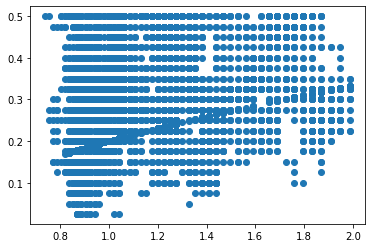

In [93]:
plt.scatter([point[0] for point in plot_points],[point[1] for point in plot_points])
plt.show()

In [103]:
losses = []
for d in [0,1]:
    for i, a in enumerate(np.linspace(1,10,101)):
        print(i)
        for b in np.linspace(1,10,101):
            for c in np.linspace(1,10,101):
                if d == 0 and c != a:
                    continue
                l = 0
                for price in prices_to_proba:
                    predict = (d*price**2 + c*price)/(d*price**2 + a*price + b)
                    for p in prices_to_proba[price]:
                        l += (predict - p)**2
                losses.append(((a,b,c),l))
print(losses)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [107]:
m = min([tup[1] for tup in losses])
k = max([tup[1] for tup in losses])
print(k)
print([tup for tup in losses if tup[1] == m])

49453.13748600456
[((10.0, 1.81, 2.71), 56.66405035184453)]


In [111]:
for i, L in enumerate(losses):
    if L[0][0] == 10.0 and L[0][1] == 1.81 and L[0][2] == 2.71:
        print(i)

1031229


In [112]:
print(len(losses))

1040502


In [114]:
l = 0
a = 10
b = 1.81
c = 2.71
d = 1
for price in prices_to_proba:
    predict = (d*price**2 + c*price)/(d*price**2 + a*price + b)
    for p in prices_to_proba[price]:
        l += (predict - p)**2 
print(l)

56.66405035184453


In [341]:
def new_get_action(sensor_data, a=0):
    global Belief, Neighbours, Adj, Sig, EvConds, Robots, outcomeSpace, Rooms, Areas
    # first, call passage of time
    Passage = {}
    for R in Areas:
        Passage[R] = passage_of_time(R, Neighbours, Belief, Adj, outcomeSpace)

    # next, call observation
    obs = convert_observation(sensor_data)
    for R in Areas:
        Belief[R] = observation(R, obs, Sig, Passage, EvConds, Robots, outcomeSpace, verbose=False)

    #create dictionary of actions
    action = {'lights' + room[1:]:None for room in Rooms}
    x = obs['electricity_price']
    if x > 1.2:
        thresh = x / (x + 4) * (1+a) - ((1+a) * 1.2)/(1.2 + 4) + 1.2/(1.2 + 4)
    else:
        thresh = x / (x + 4)
    for R in Rooms:
        if Belief[R]['table'][(1,)] > thresh:
            action['lights' + R[1:]] = 'on'
        else:
            action['lights' + R[1:]] = 'off'
    return action

In [167]:
def compare(seed, n=1):
    
    #new get_action
    reset_belief()

    np.random.seed(seed)
    simulator = SmartBuildingSimulatorExample()

    start_time = time.time()
    sensor_data = simulator.timestep()
    for i in range(len(simulator.data)-1):
        prev_cost = simulator.cost
        actions_dict = new_get_action(sensor_data,n)
        sensor_data = simulator.timestep(actions_dict)
    print(f"updated  : Total cost for the day: {simulator.cost} cents")
    
    return simulator.cost

baseline : Total cost for the day: 52977.97461606296 cents

n = 0.05
updated  : Total cost for the day: 54241.7092002549 cents

n = 0.060000000000000005
updated  : Total cost for the day: 54233.94662630107 cents

n = 0.07
updated  : Total cost for the day: 54204.204406222634 cents

n = 0.08
updated  : Total cost for the day: 54176.8020640218 cents

n = 0.09
updated  : Total cost for the day: 54169.79731824364 cents

n = 0.1
updated  : Total cost for the day: 54129.05947728841 cents

n = 0.11
updated  : Total cost for the day: 54126.70870780946 cents

n = 0.12000000000000001
updated  : Total cost for the day: 54107.32857571922 cents

n = 0.13
updated  : Total cost for the day: 54091.79549206518 cents

n = 0.14
updated  : Total cost for the day: 54086.5511012763 cents

n = 0.15000000000000002
updated  : Total cost for the day: 54074.32762909448 cents

n = 0.16
updated  : Total cost for the day: 54044.047380658696 cents

n = 0.16999999999999998
updated  : Total cost for the day: 54041.570

updated  : Total cost for the day: 52955.66362399047 cents

n = 1.1700000000000002
updated  : Total cost for the day: 52956.50707012624 cents

n = 1.1800000000000002
updated  : Total cost for the day: 52935.05348101493 cents

n = 1.1900000000000002
updated  : Total cost for the day: 52920.19715473299 cents

n = 1.2000000000000002
updated  : Total cost for the day: 52918.77945881612 cents

n = 1.21
updated  : Total cost for the day: 52904.61211311105 cents

n = 1.22
updated  : Total cost for the day: 52878.99034053136 cents

n = 1.23
updated  : Total cost for the day: 52860.71423027117 cents

n = 1.24
updated  : Total cost for the day: 52854.386927030835 cents

n = 1.25
updated  : Total cost for the day: 52831.654659556414 cents

n = 1.26
updated  : Total cost for the day: 52834.49200489799 cents

n = 1.27
updated  : Total cost for the day: 52842.41062316314 cents

n = 1.28
updated  : Total cost for the day: 52864.27561468793 cents

n = 1.29
updated  : Total cost for the day: 52871.8837

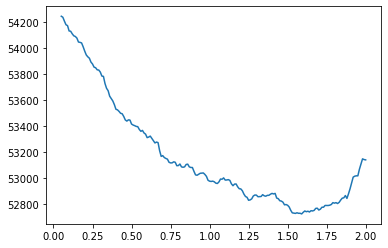

In [169]:
# current get_action
global Belief
reset_belief()

np.random.seed(2020)
simulator = SmartBuildingSimulatorExample()

start_time = time.time()
sensor_data = simulator.timestep()
for i in range(len(simulator.data)-1):
    prev_cost = simulator.cost
    actions_dict = get_action(sensor_data)
    sensor_data = simulator.timestep(actions_dict)
print(f"baseline : Total cost for the day: {simulator.cost} cents")

costs = []
for n in np.linspace(0.05,2,196):
    print()
    print(f'n = {n}')
    costs.append(compare(2020,n))
    
plt.plot(np.linspace(0.05,2,196),costs)
plt.show()

In [344]:
import time

def new_run(a, *, num_sims=1):
    
    print(f'Testing: a = {a}')
    print()
    
    bad = 0
    good = 0
    
    curr_costs = []
    new_costs = []
    
    for j in range(num_sims):
        
        print(j)
        print()
            
        #t = int(time.time())

        #get_action

        global Belief
        reset_belief()

        np.random.seed(j)
        simulator = SmartBuildingSimulatorExample()
        
        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):         
            actions_dict = get_action(sensor_data)
            sensor_data = simulator.timestep(actions_dict)
        print(f" -- get_action : Total cost for the day: {simulator.cost} cents")
        print(f" -- -- Time taken: {time.time() - start_time}")
        curr_costs.append(simulator.cost)

        #get_action

        global Belief
        reset_belief()

        np.random.seed(j)
        simulator = SmartBuildingSimulatorExample()
        
        start_time = time.time()
        sensor_data = simulator.timestep()
        for i in range(len(simulator.data)-1):
            actions_dict = new_get_action(sensor_data, a)
            sensor_data = simulator.timestep(actions_dict)
        print(f" -- new get_action : Total cost for the day: {simulator.cost} cents")
        print(f" -- -- Time taken: {time.time() - start_time}")
        new_costs.append(simulator.cost)
        
        if curr_costs[-1] > new_costs[-1]:
            good += 1
        if curr_costs[-1] < new_costs[-1]:
            bad += 1
            
        print()
            
    print(f'Method performed worse than original {bad} times')
    print(f'Method performed better than original {good} times')
    print(f'Average costs: get_action: {np.mean(curr_costs)}')
    print(f'Average costs: new_get_action: {np.mean(new_costs)}')
    
    return np.mean(curr_costs), np.mean(new_costs)
            
def reset_belief():
    global Belief
    Belief = Priors.copy()

In [345]:
#p, c, b = new_run(100)

olds = []
news = []

for a in np.linspace(0,0.5,num=51):
    old_mean, new_mean = new_run(a, num_sims=50)
    olds.append(old_mean)
    news.append(new_mean)

Testing: a = 0.0

0

 -- get_action : Total cost for the day: 67812.20377284776 cents
 -- -- Time taken: 10.90599274635315
 -- new get_action : Total cost for the day: 67812.20377284776 cents
 -- -- Time taken: 10.909518480300903

1

 -- get_action : Total cost for the day: 42640.17862613423 cents
 -- -- Time taken: 10.957922458648682
 -- new get_action : Total cost for the day: 42640.17862613423 cents
 -- -- Time taken: 11.748589038848877

2

 -- get_action : Total cost for the day: 82975.03747026488 cents
 -- -- Time taken: 11.231848001480103
 -- new get_action : Total cost for the day: 82975.03747026488 cents
 -- -- Time taken: 11.02573823928833

3

 -- get_action : Total cost for the day: 52974.044193686896 cents
 -- -- Time taken: 10.907899141311646
 -- new get_action : Total cost for the day: 52974.044193686896 cents
 -- -- Time taken: 10.690809726715088

4

 -- get_action : Total cost for the day: 50270.65248104603 cents
 -- -- Time taken: 11.450748682022095
 -- new get_action :

 -- new get_action : Total cost for the day: 82922.7753727406 cents
 -- -- Time taken: 11.180208921432495

39

 -- get_action : Total cost for the day: 63614.73701218509 cents
 -- -- Time taken: 11.29486894607544
 -- new get_action : Total cost for the day: 63614.73701218509 cents
 -- -- Time taken: 11.055117845535278

40

 -- get_action : Total cost for the day: 118666.33062557415 cents
 -- -- Time taken: 11.110877275466919
 -- new get_action : Total cost for the day: 118666.33062557415 cents
 -- -- Time taken: 11.364450931549072

41

 -- get_action : Total cost for the day: 85302.2447959197 cents
 -- -- Time taken: 11.274340152740479
 -- new get_action : Total cost for the day: 85302.2447959197 cents
 -- -- Time taken: 11.166507005691528

42

 -- get_action : Total cost for the day: 52126.217280172656 cents
 -- -- Time taken: 11.504878997802734
 -- new get_action : Total cost for the day: 52126.217280172656 cents
 -- -- Time taken: 12.082476377487183

43

 -- get_action : Total cost 

 -- get_action : Total cost for the day: 60612.8410480033 cents
 -- -- Time taken: 11.218007802963257
 -- new get_action : Total cost for the day: 60608.94401618398 cents
 -- -- Time taken: 11.072469711303711

27

 -- get_action : Total cost for the day: 42718.40755561596 cents
 -- -- Time taken: 11.42688775062561
 -- new get_action : Total cost for the day: 42718.40755561596 cents
 -- -- Time taken: 11.103221654891968

28

 -- get_action : Total cost for the day: 51019.41863114059 cents
 -- -- Time taken: 11.1562659740448
 -- new get_action : Total cost for the day: 51018.11827888301 cents
 -- -- Time taken: 11.341224670410156

29

 -- get_action : Total cost for the day: 36222.85338668315 cents
 -- -- Time taken: 11.365976572036743
 -- new get_action : Total cost for the day: 36222.85338668315 cents
 -- -- Time taken: 11.30918264389038

30

 -- get_action : Total cost for the day: 52464.067649885954 cents
 -- -- Time taken: 11.308906555175781
 -- new get_action : Total cost for the d

 -- new get_action : Total cost for the day: 38179.85357773556 cents
 -- -- Time taken: 11.073314666748047

14

 -- get_action : Total cost for the day: 27229.92747132457 cents
 -- -- Time taken: 11.371915578842163
 -- new get_action : Total cost for the day: 27229.92747132457 cents
 -- -- Time taken: 11.370745420455933

15

 -- get_action : Total cost for the day: 71167.58642372268 cents
 -- -- Time taken: 11.339166402816772
 -- new get_action : Total cost for the day: 71110.90546040819 cents
 -- -- Time taken: 11.355478525161743

16

 -- get_action : Total cost for the day: 67985.72609944877 cents
 -- -- Time taken: 11.233413457870483
 -- new get_action : Total cost for the day: 67990.66399181078 cents
 -- -- Time taken: 11.424319744110107

17

 -- get_action : Total cost for the day: 82380.16899148951 cents
 -- -- Time taken: 11.423031330108643
 -- new get_action : Total cost for the day: 82311.65999652313 cents
 -- -- Time taken: 11.18070125579834

18

 -- get_action : Total cost f

 -- get_action : Total cost for the day: 42640.17862613423 cents
 -- -- Time taken: 10.933597087860107
 -- new get_action : Total cost for the day: 42640.17862613423 cents
 -- -- Time taken: 11.003580570220947

2

 -- get_action : Total cost for the day: 82975.03747026488 cents
 -- -- Time taken: 11.085864305496216
 -- new get_action : Total cost for the day: 82867.24606812852 cents
 -- -- Time taken: 11.457160234451294

3

 -- get_action : Total cost for the day: 52974.044193686896 cents
 -- -- Time taken: 11.361895322799683
 -- new get_action : Total cost for the day: 52975.33404400355 cents
 -- -- Time taken: 10.936161994934082

4

 -- get_action : Total cost for the day: 50270.65248104603 cents
 -- -- Time taken: 10.754771947860718
 -- new get_action : Total cost for the day: 50270.65248104603 cents
 -- -- Time taken: 10.753032445907593

5

 -- get_action : Total cost for the day: 70579.11054166123 cents
 -- -- Time taken: 11.39977240562439
 -- new get_action : Total cost for the d

 -- new get_action : Total cost for the day: 63577.10855252548 cents
 -- -- Time taken: 11.883516073226929

40

 -- get_action : Total cost for the day: 118666.33062557415 cents
 -- -- Time taken: 11.879219055175781
 -- new get_action : Total cost for the day: 117562.07198295768 cents
 -- -- Time taken: 11.669790744781494

41

 -- get_action : Total cost for the day: 85302.2447959197 cents
 -- -- Time taken: 12.336321115493774
 -- new get_action : Total cost for the day: 85161.22579593459 cents
 -- -- Time taken: 12.396579504013062

42

 -- get_action : Total cost for the day: 52126.217280172656 cents
 -- -- Time taken: 12.447392463684082
 -- new get_action : Total cost for the day: 52126.12552901207 cents
 -- -- Time taken: 11.972987174987793

43

 -- get_action : Total cost for the day: 54587.67494881587 cents
 -- -- Time taken: 12.181574583053589
 -- new get_action : Total cost for the day: 54591.58485580261 cents
 -- -- Time taken: 12.090621948242188

44

 -- get_action : Total cos

 -- get_action : Total cost for the day: 42718.40755561596 cents
 -- -- Time taken: 11.107001066207886
 -- new get_action : Total cost for the day: 42718.40755561596 cents
 -- -- Time taken: 10.958152770996094

28

 -- get_action : Total cost for the day: 51019.41863114059 cents
 -- -- Time taken: 10.759999990463257
 -- new get_action : Total cost for the day: 51018.11827888301 cents
 -- -- Time taken: 10.989197254180908

29

 -- get_action : Total cost for the day: 36222.85338668315 cents
 -- -- Time taken: 10.735337495803833
 -- new get_action : Total cost for the day: 36222.85338668315 cents
 -- -- Time taken: 10.602360963821411

30

 -- get_action : Total cost for the day: 52464.067649885954 cents
 -- -- Time taken: 10.965043306350708
 -- new get_action : Total cost for the day: 52464.067649885954 cents
 -- -- Time taken: 10.774567604064941

31

 -- get_action : Total cost for the day: 46976.7929677661 cents
 -- -- Time taken: 10.818175077438354
 -- new get_action : Total cost for 

 -- new get_action : Total cost for the day: 27229.92747132457 cents
 -- -- Time taken: 11.442380428314209

15

 -- get_action : Total cost for the day: 71167.58642372268 cents
 -- -- Time taken: 11.80666184425354
 -- new get_action : Total cost for the day: 71029.12312204715 cents
 -- -- Time taken: 11.44576907157898

16

 -- get_action : Total cost for the day: 67985.72609944877 cents
 -- -- Time taken: 11.264161109924316
 -- new get_action : Total cost for the day: 67993.90623999132 cents
 -- -- Time taken: 11.19097900390625

17

 -- get_action : Total cost for the day: 82380.16899148951 cents
 -- -- Time taken: 10.946394205093384
 -- new get_action : Total cost for the day: 82280.83720595486 cents
 -- -- Time taken: 10.461023330688477

18

 -- get_action : Total cost for the day: 54155.416053573164 cents
 -- -- Time taken: 11.091358184814453
 -- new get_action : Total cost for the day: 54135.3842751608 cents
 -- -- Time taken: 11.250438928604126

19

 -- get_action : Total cost for

 -- get_action : Total cost for the day: 82975.03747026488 cents
 -- -- Time taken: 12.186586856842041
 -- new get_action : Total cost for the day: 82830.38852292846 cents
 -- -- Time taken: 11.801508903503418

3

 -- get_action : Total cost for the day: 52974.044193686896 cents
 -- -- Time taken: 12.433603286743164
 -- new get_action : Total cost for the day: 52975.33404400355 cents
 -- -- Time taken: 11.968504190444946

4

 -- get_action : Total cost for the day: 50270.65248104603 cents
 -- -- Time taken: 12.187198400497437
 -- new get_action : Total cost for the day: 50270.65248104603 cents
 -- -- Time taken: 11.673710584640503

5

 -- get_action : Total cost for the day: 70579.11054166123 cents
 -- -- Time taken: 12.476103067398071
 -- new get_action : Total cost for the day: 70579.98650972992 cents
 -- -- Time taken: 11.441543817520142

6

 -- get_action : Total cost for the day: 100366.72532361947 cents
 -- -- Time taken: 12.069879531860352
 -- new get_action : Total cost for the

 -- new get_action : Total cost for the day: 116392.06766044875 cents
 -- -- Time taken: 11.882364988327026

41

 -- get_action : Total cost for the day: 85302.2447959197 cents
 -- -- Time taken: 12.185606241226196
 -- new get_action : Total cost for the day: 85033.75067940186 cents
 -- -- Time taken: 11.800256490707397

42

 -- get_action : Total cost for the day: 52126.217280172656 cents
 -- -- Time taken: 12.148908376693726
 -- new get_action : Total cost for the day: 52125.86678993122 cents
 -- -- Time taken: 12.146612167358398

43

 -- get_action : Total cost for the day: 54587.67494881587 cents
 -- -- Time taken: 11.703557252883911
 -- new get_action : Total cost for the day: 54588.8316845772 cents
 -- -- Time taken: 11.993880987167358

44

 -- get_action : Total cost for the day: 34523.362300168046 cents
 -- -- Time taken: 12.110220432281494
 -- new get_action : Total cost for the day: 34523.362300168046 cents
 -- -- Time taken: 12.019667863845825

45

 -- get_action : Total cos

 -- get_action : Total cost for the day: 51019.41863114059 cents
 -- -- Time taken: 12.140069007873535
 -- new get_action : Total cost for the day: 51016.81792662544 cents
 -- -- Time taken: 12.17107105255127

29

 -- get_action : Total cost for the day: 36222.85338668315 cents
 -- -- Time taken: 11.87026596069336
 -- new get_action : Total cost for the day: 36222.85338668315 cents
 -- -- Time taken: 11.508852005004883

30

 -- get_action : Total cost for the day: 52464.067649885954 cents
 -- -- Time taken: 12.139599084854126
 -- new get_action : Total cost for the day: 52462.81879157778 cents
 -- -- Time taken: 12.479939222335815

31

 -- get_action : Total cost for the day: 46976.7929677661 cents
 -- -- Time taken: 11.835378885269165
 -- new get_action : Total cost for the day: 46976.7929677661 cents
 -- -- Time taken: 11.913234949111938

32

 -- get_action : Total cost for the day: 50318.222612664 cents
 -- -- Time taken: 11.991364002227783
 -- new get_action : Total cost for the da

 -- new get_action : Total cost for the day: 70999.80838582476 cents
 -- -- Time taken: 11.69516897201538

16

 -- get_action : Total cost for the day: 67985.72609944877 cents
 -- -- Time taken: 12.203266620635986
 -- new get_action : Total cost for the day: 67990.92570773688 cents
 -- -- Time taken: 11.874451160430908

17

 -- get_action : Total cost for the day: 82380.16899148951 cents
 -- -- Time taken: 12.381325483322144
 -- new get_action : Total cost for the day: 82134.19943379276 cents
 -- -- Time taken: 11.838091373443604

18

 -- get_action : Total cost for the day: 54155.416053573164 cents
 -- -- Time taken: 12.155750036239624
 -- new get_action : Total cost for the day: 54132.91027638159 cents
 -- -- Time taken: 12.404188632965088

19

 -- get_action : Total cost for the day: 52028.74374119495 cents
 -- -- Time taken: 12.552876234054565
 -- new get_action : Total cost for the day: 52032.67149382537 cents
 -- -- Time taken: 11.687981367111206

20

 -- get_action : Total cost 

 -- get_action : Total cost for the day: 52974.044193686896 cents
 -- -- Time taken: 12.296730995178223
 -- new get_action : Total cost for the day: 52979.24115349648 cents
 -- -- Time taken: 11.75880742073059

4

 -- get_action : Total cost for the day: 50270.65248104603 cents
 -- -- Time taken: 11.875931024551392
 -- new get_action : Total cost for the day: 50270.65248104603 cents
 -- -- Time taken: 12.335583925247192

5

 -- get_action : Total cost for the day: 70579.11054166123 cents
 -- -- Time taken: 12.328476428985596
 -- new get_action : Total cost for the day: 70613.21672843456 cents
 -- -- Time taken: 11.981282472610474

6

 -- get_action : Total cost for the day: 100366.72532361947 cents
 -- -- Time taken: 11.99512767791748
 -- new get_action : Total cost for the day: 99829.37264013971 cents
 -- -- Time taken: 11.9200758934021

7

 -- get_action : Total cost for the day: 73950.71205287383 cents
 -- -- Time taken: 11.911081552505493
 -- new get_action : Total cost for the day

 -- new get_action : Total cost for the day: 85005.67369120104 cents
 -- -- Time taken: 10.614676475524902

42

 -- get_action : Total cost for the day: 52126.217280172656 cents
 -- -- Time taken: 11.35608172416687
 -- new get_action : Total cost for the day: 52125.86678993122 cents
 -- -- Time taken: 10.696690797805786

43

 -- get_action : Total cost for the day: 54587.67494881587 cents
 -- -- Time taken: 10.840859174728394
 -- new get_action : Total cost for the day: 54586.02864438678 cents
 -- -- Time taken: 10.446877241134644

44

 -- get_action : Total cost for the day: 34523.362300168046 cents
 -- -- Time taken: 11.033912658691406
 -- new get_action : Total cost for the day: 34523.362300168046 cents
 -- -- Time taken: 10.635141134262085

45

 -- get_action : Total cost for the day: 79574.33999645669 cents
 -- -- Time taken: 10.784391403198242
 -- new get_action : Total cost for the day: 79308.57874336523 cents
 -- -- Time taken: 10.755065441131592

46

 -- get_action : Total cos

 -- get_action : Total cost for the day: 36222.85338668315 cents
 -- -- Time taken: 10.959321975708008
 -- new get_action : Total cost for the day: 36222.85338668315 cents
 -- -- Time taken: 10.9447660446167

30

 -- get_action : Total cost for the day: 52464.067649885954 cents
 -- -- Time taken: 10.747182369232178
 -- new get_action : Total cost for the day: 52465.56993326961 cents
 -- -- Time taken: 10.765363693237305

31

 -- get_action : Total cost for the day: 46976.7929677661 cents
 -- -- Time taken: 11.11920428276062
 -- new get_action : Total cost for the day: 46976.7929677661 cents
 -- -- Time taken: 10.639950513839722

32

 -- get_action : Total cost for the day: 50318.222612664 cents
 -- -- Time taken: 10.8969087600708
 -- new get_action : Total cost for the day: 50296.80935008882 cents
 -- -- Time taken: 10.662044048309326

33

 -- get_action : Total cost for the day: 54689.152998577876 cents
 -- -- Time taken: 11.251110315322876
 -- new get_action : Total cost for the day:

 -- new get_action : Total cost for the day: 67990.9816611115 cents
 -- -- Time taken: 11.330219507217407

17

 -- get_action : Total cost for the day: 82380.16899148951 cents
 -- -- Time taken: 11.092369079589844
 -- new get_action : Total cost for the day: 82085.7110640138 cents
 -- -- Time taken: 11.406024932861328

18

 -- get_action : Total cost for the day: 54155.416053573164 cents
 -- -- Time taken: 11.381933689117432
 -- new get_action : Total cost for the day: 54119.92896767029 cents
 -- -- Time taken: 10.9435133934021

19

 -- get_action : Total cost for the day: 52028.74374119495 cents
 -- -- Time taken: 11.404667615890503
 -- new get_action : Total cost for the day: 52032.873945092346 cents
 -- -- Time taken: 11.217223405838013

20

 -- get_action : Total cost for the day: 56392.92148273725 cents
 -- -- Time taken: 11.249154090881348
 -- new get_action : Total cost for the day: 56368.887531454806 cents
 -- -- Time taken: 10.762314081192017

21

 -- get_action : Total cost f

 -- get_action : Total cost for the day: 50270.65248104603 cents
 -- -- Time taken: 12.281099557876587
 -- new get_action : Total cost for the day: 50270.65248104603 cents
 -- -- Time taken: 11.997023582458496

5

 -- get_action : Total cost for the day: 70579.11054166123 cents
 -- -- Time taken: 12.618095397949219
 -- new get_action : Total cost for the day: 70609.17925064651 cents
 -- -- Time taken: 11.271180629730225

6

 -- get_action : Total cost for the day: 100366.72532361947 cents
 -- -- Time taken: 11.140405654907227
 -- new get_action : Total cost for the day: 99733.50472011267 cents
 -- -- Time taken: 10.863176107406616

7

 -- get_action : Total cost for the day: 73950.71205287383 cents
 -- -- Time taken: 11.469851016998291
 -- new get_action : Total cost for the day: 73631.04020651561 cents
 -- -- Time taken: 10.80397367477417

8

 -- get_action : Total cost for the day: 50949.22346799322 cents
 -- -- Time taken: 11.023715019226074
 -- new get_action : Total cost for the d

 -- new get_action : Total cost for the day: 52125.86678993122 cents
 -- -- Time taken: 11.140011548995972

43

 -- get_action : Total cost for the day: 54587.67494881587 cents
 -- -- Time taken: 10.981008529663086
 -- new get_action : Total cost for the day: 54588.77665829594 cents
 -- -- Time taken: 11.553245067596436

44

 -- get_action : Total cost for the day: 34523.362300168046 cents
 -- -- Time taken: 10.865381240844727
 -- new get_action : Total cost for the day: 34523.362300168046 cents
 -- -- Time taken: 11.363898038864136

45

 -- get_action : Total cost for the day: 79574.33999645669 cents
 -- -- Time taken: 11.527867794036865
 -- new get_action : Total cost for the day: 79266.68318475346 cents
 -- -- Time taken: 11.337105751037598

46

 -- get_action : Total cost for the day: 96100.62227053227 cents
 -- -- Time taken: 11.115363359451294
 -- new get_action : Total cost for the day: 95319.2376953019 cents
 -- -- Time taken: 10.87999153137207

47

 -- get_action : Total cost 

 -- get_action : Total cost for the day: 52464.067649885954 cents
 -- -- Time taken: 11.299601316452026
 -- new get_action : Total cost for the day: 52465.56993326961 cents
 -- -- Time taken: 10.935878992080688

31

 -- get_action : Total cost for the day: 46976.7929677661 cents
 -- -- Time taken: 10.800533294677734
 -- new get_action : Total cost for the day: 46976.7929677661 cents
 -- -- Time taken: 10.69198751449585

32

 -- get_action : Total cost for the day: 50318.222612664 cents
 -- -- Time taken: 10.873686790466309
 -- new get_action : Total cost for the day: 50290.011318180164 cents
 -- -- Time taken: 10.759439706802368

33

 -- get_action : Total cost for the day: 54689.152998577876 cents
 -- -- Time taken: 10.762264251708984
 -- new get_action : Total cost for the day: 54685.863910960135 cents
 -- -- Time taken: 10.973553895950317

34

 -- get_action : Total cost for the day: 53488.22968608688 cents
 -- -- Time taken: 11.04372525215149
 -- new get_action : Total cost for the

 -- new get_action : Total cost for the day: 81955.97964232037 cents
 -- -- Time taken: 10.815989971160889

18

 -- get_action : Total cost for the day: 54155.416053573164 cents
 -- -- Time taken: 10.702665567398071
 -- new get_action : Total cost for the day: 54119.61558283031 cents
 -- -- Time taken: 10.910251379013062

19

 -- get_action : Total cost for the day: 52028.74374119495 cents
 -- -- Time taken: 11.402828454971313
 -- new get_action : Total cost for the day: 52034.240266524575 cents
 -- -- Time taken: 10.722308158874512

20

 -- get_action : Total cost for the day: 56392.92148273725 cents
 -- -- Time taken: 10.65968918800354
 -- new get_action : Total cost for the day: 56357.343905217 cents
 -- -- Time taken: 10.755921363830566

21

 -- get_action : Total cost for the day: 99818.3885565133 cents
 -- -- Time taken: 11.035001993179321
 -- new get_action : Total cost for the day: 99320.60754042267 cents
 -- -- Time taken: 10.737347602844238

22

 -- get_action : Total cost fo

 -- get_action : Total cost for the day: 70579.11054166123 cents
 -- -- Time taken: 12.059318780899048
 -- new get_action : Total cost for the day: 70596.22240361337 cents
 -- -- Time taken: 12.032226085662842

6

 -- get_action : Total cost for the day: 100366.72532361947 cents
 -- -- Time taken: 12.565454721450806
 -- new get_action : Total cost for the day: 99582.37211196467 cents
 -- -- Time taken: 12.010127305984497

7

 -- get_action : Total cost for the day: 73950.71205287383 cents
 -- -- Time taken: 12.355578422546387
 -- new get_action : Total cost for the day: 73576.77385812512 cents
 -- -- Time taken: 12.030004262924194

8

 -- get_action : Total cost for the day: 50949.22346799322 cents
 -- -- Time taken: 12.241980075836182
 -- new get_action : Total cost for the day: 50950.67425742747 cents
 -- -- Time taken: 12.448203563690186

9

 -- get_action : Total cost for the day: 69081.24015779831 cents
 -- -- Time taken: 12.305381536483765
 -- new get_action : Total cost for the 

 -- new get_action : Total cost for the day: 54583.412728495096 cents
 -- -- Time taken: 12.288306713104248

44

 -- get_action : Total cost for the day: 34523.362300168046 cents
 -- -- Time taken: 12.148716688156128
 -- new get_action : Total cost for the day: 34523.362300168046 cents
 -- -- Time taken: 12.040224075317383

45

 -- get_action : Total cost for the day: 79574.33999645669 cents
 -- -- Time taken: 11.765164613723755
 -- new get_action : Total cost for the day: 79156.18905619989 cents
 -- -- Time taken: 12.191758632659912

46

 -- get_action : Total cost for the day: 96100.62227053227 cents
 -- -- Time taken: 11.96956491470337
 -- new get_action : Total cost for the day: 95110.04482286796 cents
 -- -- Time taken: 12.021530866622925

47

 -- get_action : Total cost for the day: 49308.72166882876 cents
 -- -- Time taken: 12.450174331665039
 -- new get_action : Total cost for the day: 49304.968395235956 cents
 -- -- Time taken: 12.137478590011597

48

 -- get_action : Total co

 -- get_action : Total cost for the day: 46976.7929677661 cents
 -- -- Time taken: 12.612210035324097
 -- new get_action : Total cost for the day: 46976.7929677661 cents
 -- -- Time taken: 12.38694715499878

32

 -- get_action : Total cost for the day: 50318.222612664 cents
 -- -- Time taken: 11.966137647628784
 -- new get_action : Total cost for the day: 50286.01915743181 cents
 -- -- Time taken: 11.986721277236938

33

 -- get_action : Total cost for the day: 54689.152998577876 cents
 -- -- Time taken: 12.263983011245728
 -- new get_action : Total cost for the day: 54678.967494624725 cents
 -- -- Time taken: 11.747795343399048

34

 -- get_action : Total cost for the day: 53488.22968608688 cents
 -- -- Time taken: 11.832306146621704
 -- new get_action : Total cost for the day: 53485.60244377056 cents
 -- -- Time taken: 11.772270441055298

35

 -- get_action : Total cost for the day: 36911.70254637753 cents
 -- -- Time taken: 11.875785112380981
 -- new get_action : Total cost for the 

 -- new get_action : Total cost for the day: 54110.37709167129 cents
 -- -- Time taken: 11.439862966537476

19

 -- get_action : Total cost for the day: 52028.74374119495 cents
 -- -- Time taken: 11.075456619262695
 -- new get_action : Total cost for the day: 52034.240266524575 cents
 -- -- Time taken: 10.617682456970215

20

 -- get_action : Total cost for the day: 56392.92148273725 cents
 -- -- Time taken: 11.153347492218018
 -- new get_action : Total cost for the day: 56353.746706525606 cents
 -- -- Time taken: 11.082677125930786

21

 -- get_action : Total cost for the day: 99818.3885565133 cents
 -- -- Time taken: 11.006669521331787
 -- new get_action : Total cost for the day: 99170.9253531185 cents
 -- -- Time taken: 10.560765027999878

22

 -- get_action : Total cost for the day: 36127.3835607362 cents
 -- -- Time taken: 10.839269638061523
 -- new get_action : Total cost for the day: 36120.87704322878 cents
 -- -- Time taken: 10.570543050765991

23

 -- get_action : Total cost f

 -- get_action : Total cost for the day: 100366.72532361947 cents
 -- -- Time taken: 10.75609827041626
 -- new get_action : Total cost for the day: 99490.62945667107 cents
 -- -- Time taken: 10.8187735080719

7

 -- get_action : Total cost for the day: 73950.71205287383 cents
 -- -- Time taken: 11.177841424942017
 -- new get_action : Total cost for the day: 73464.77759173031 cents
 -- -- Time taken: 10.558531522750854

8

 -- get_action : Total cost for the day: 50949.22346799322 cents
 -- -- Time taken: 10.916796207427979
 -- new get_action : Total cost for the day: 50950.67425742747 cents
 -- -- Time taken: 10.4877769947052

9

 -- get_action : Total cost for the day: 69081.24015779831 cents
 -- -- Time taken: 10.871703147888184
 -- new get_action : Total cost for the day: 69195.45365814658 cents
 -- -- Time taken: 10.61107611656189

10

 -- get_action : Total cost for the day: 56238.53054958696 cents
 -- -- Time taken: 10.868309259414673
 -- new get_action : Total cost for the day: 

 -- new get_action : Total cost for the day: 34523.362300168046 cents
 -- -- Time taken: 10.714312553405762

45

 -- get_action : Total cost for the day: 79574.33999645669 cents
 -- -- Time taken: 11.060664176940918
 -- new get_action : Total cost for the day: 79121.44780267913 cents
 -- -- Time taken: 10.88578200340271

46

 -- get_action : Total cost for the day: 96100.62227053227 cents
 -- -- Time taken: 10.87097978591919
 -- new get_action : Total cost for the day: 94952.62374795426 cents
 -- -- Time taken: 10.821026802062988

47

 -- get_action : Total cost for the day: 49308.72166882876 cents
 -- -- Time taken: 10.955421447753906
 -- new get_action : Total cost for the day: 49303.694050023536 cents
 -- -- Time taken: 10.70008134841919

48

 -- get_action : Total cost for the day: 50925.64439671969 cents
 -- -- Time taken: 11.00004768371582
 -- new get_action : Total cost for the day: 50849.581056001996 cents
 -- -- Time taken: 10.802051544189453

49

 -- get_action : Total cost f

 -- get_action : Total cost for the day: 50318.222612664 cents
 -- -- Time taken: 10.582205772399902
 -- new get_action : Total cost for the day: 50279.10162858429 cents
 -- -- Time taken: 10.790103197097778

33

 -- get_action : Total cost for the day: 54689.152998577876 cents
 -- -- Time taken: 10.951515197753906
 -- new get_action : Total cost for the day: 54676.17182993261 cents
 -- -- Time taken: 10.653090000152588

34

 -- get_action : Total cost for the day: 53488.22968608688 cents
 -- -- Time taken: 11.080603122711182
 -- new get_action : Total cost for the day: 53485.60244377056 cents
 -- -- Time taken: 10.997451066970825

35

 -- get_action : Total cost for the day: 36911.70254637753 cents
 -- -- Time taken: 10.653883457183838
 -- new get_action : Total cost for the day: 36911.70254637753 cents
 -- -- Time taken: 10.689805269241333

36

 -- get_action : Total cost for the day: 144178.22323387975 cents
 -- -- Time taken: 10.706519603729248
 -- new get_action : Total cost for t

 -- new get_action : Total cost for the day: 52033.016385382565 cents
 -- -- Time taken: 11.060080289840698

20

 -- get_action : Total cost for the day: 56392.92148273725 cents
 -- -- Time taken: 10.677734375
 -- new get_action : Total cost for the day: 56341.48672906915 cents
 -- -- Time taken: 10.557356119155884

21

 -- get_action : Total cost for the day: 99818.3885565133 cents
 -- -- Time taken: 10.977978229522705
 -- new get_action : Total cost for the day: 99035.79392749579 cents
 -- -- Time taken: 10.489304542541504

22

 -- get_action : Total cost for the day: 36127.3835607362 cents
 -- -- Time taken: 10.849199533462524
 -- new get_action : Total cost for the day: 36122.301294861856 cents
 -- -- Time taken: 10.853428363800049

23

 -- get_action : Total cost for the day: 64609.28447373107 cents
 -- -- Time taken: 11.135169267654419
 -- new get_action : Total cost for the day: 64452.240743016126 cents
 -- -- Time taken: 10.71322512626648

24

 -- get_action : Total cost for th

 -- get_action : Total cost for the day: 73950.71205287383 cents
 -- -- Time taken: 10.656234979629517
 -- new get_action : Total cost for the day: 73359.76641949674 cents
 -- -- Time taken: 10.781428337097168

8

 -- get_action : Total cost for the day: 50949.22346799322 cents
 -- -- Time taken: 10.759803771972656
 -- new get_action : Total cost for the day: 50950.67425742747 cents
 -- -- Time taken: 10.981513261795044

9

 -- get_action : Total cost for the day: 69081.24015779831 cents
 -- -- Time taken: 10.724119424819946
 -- new get_action : Total cost for the day: 69191.71647213849 cents
 -- -- Time taken: 10.598626852035522

10

 -- get_action : Total cost for the day: 56238.53054958696 cents
 -- -- Time taken: 10.779343843460083
 -- new get_action : Total cost for the day: 56242.6893281062 cents
 -- -- Time taken: 10.574100255966187

11

 -- get_action : Total cost for the day: 45175.16755308623 cents
 -- -- Time taken: 10.739351272583008
 -- new get_action : Total cost for the 

 -- new get_action : Total cost for the day: 79105.76101050277 cents
 -- -- Time taken: 11.39374852180481

46

 -- get_action : Total cost for the day: 96100.62227053227 cents
 -- -- Time taken: 11.592987537384033
 -- new get_action : Total cost for the day: 94854.2449847649 cents
 -- -- Time taken: 11.238590002059937

47

 -- get_action : Total cost for the day: 49308.72166882876 cents
 -- -- Time taken: 11.2739839553833
 -- new get_action : Total cost for the day: 49302.393697765954 cents
 -- -- Time taken: 11.580968856811523

48

 -- get_action : Total cost for the day: 50925.64439671969 cents
 -- -- Time taken: 11.641687393188477
 -- new get_action : Total cost for the day: 50818.697261827954 cents
 -- -- Time taken: 11.497883796691895

49

 -- get_action : Total cost for the day: 60175.14096011765 cents
 -- -- Time taken: 11.46545958518982
 -- new get_action : Total cost for the day: 60182.423541322765 cents
 -- -- Time taken: 11.304131507873535

Method performed worse than origin

 -- get_action : Total cost for the day: 54689.152998577876 cents
 -- -- Time taken: 10.813743829727173
 -- new get_action : Total cost for the day: 54673.29469232901 cents
 -- -- Time taken: 10.648900270462036

34

 -- get_action : Total cost for the day: 53488.22968608688 cents
 -- -- Time taken: 11.045487880706787
 -- new get_action : Total cost for the day: 53484.22084229331 cents
 -- -- Time taken: 10.627729654312134

35

 -- get_action : Total cost for the day: 36911.70254637753 cents
 -- -- Time taken: 11.079369306564331
 -- new get_action : Total cost for the day: 36911.70254637753 cents
 -- -- Time taken: 10.846193552017212

36

 -- get_action : Total cost for the day: 144178.22323387975 cents
 -- -- Time taken: 11.002725839614868
 -- new get_action : Total cost for the day: 137940.82858121424 cents
 -- -- Time taken: 11.166743755340576

37

 -- get_action : Total cost for the day: 45214.218952834795 cents
 -- -- Time taken: 10.549616575241089
 -- new get_action : Total cost f

 -- new get_action : Total cost for the day: 56331.9379773313 cents
 -- -- Time taken: 11.90349555015564

21

 -- get_action : Total cost for the day: 99818.3885565133 cents
 -- -- Time taken: 12.304491758346558
 -- new get_action : Total cost for the day: 98873.57420051398 cents
 -- -- Time taken: 11.92512845993042

22

 -- get_action : Total cost for the day: 36127.3835607362 cents
 -- -- Time taken: 12.310765981674194
 -- new get_action : Total cost for the day: 36121.00094260428 cents
 -- -- Time taken: 11.974117279052734

23

 -- get_action : Total cost for the day: 64609.28447373107 cents
 -- -- Time taken: 12.226863622665405
 -- new get_action : Total cost for the day: 64473.83920946339 cents
 -- -- Time taken: 11.717962741851807

24

 -- get_action : Total cost for the day: 49582.191226327996 cents
 -- -- Time taken: 11.701210975646973
 -- new get_action : Total cost for the day: 49582.191226327996 cents
 -- -- Time taken: 11.51916217803955

25

 -- get_action : Total cost for 

 -- get_action : Total cost for the day: 50949.22346799322 cents
 -- -- Time taken: 10.699264526367188
 -- new get_action : Total cost for the day: 50949.34736736872 cents
 -- -- Time taken: 11.01101803779602

9

 -- get_action : Total cost for the day: 69081.24015779831 cents
 -- -- Time taken: 10.956906080245972
 -- new get_action : Total cost for the day: 69158.77205115772 cents
 -- -- Time taken: 10.601072549819946

10

 -- get_action : Total cost for the day: 56238.53054958696 cents
 -- -- Time taken: 10.863702535629272
 -- new get_action : Total cost for the day: 56253.3276090933 cents
 -- -- Time taken: 10.664709329605103

11

 -- get_action : Total cost for the day: 45175.16755308623 cents
 -- -- Time taken: 10.732387781143188
 -- new get_action : Total cost for the day: 45175.16755308623 cents
 -- -- Time taken: 11.023748397827148

12

 -- get_action : Total cost for the day: 36959.79377768372 cents
 -- -- Time taken: 11.263209342956543
 -- new get_action : Total cost for the 

 -- new get_action : Total cost for the day: 94810.19525853741 cents
 -- -- Time taken: 10.978591680526733

47

 -- get_action : Total cost for the day: 49308.72166882876 cents
 -- -- Time taken: 10.87113618850708
 -- new get_action : Total cost for the day: 49302.393697765954 cents
 -- -- Time taken: 10.868382692337036

48

 -- get_action : Total cost for the day: 50925.64439671969 cents
 -- -- Time taken: 10.741140365600586
 -- new get_action : Total cost for the day: 50803.35115137828 cents
 -- -- Time taken: 10.932530164718628

49

 -- get_action : Total cost for the day: 60175.14096011765 cents
 -- -- Time taken: 10.835453987121582
 -- new get_action : Total cost for the day: 60179.125657200035 cents
 -- -- Time taken: 10.717426776885986

Method performed worse than original 12 times
Method performed better than original 25 times
Average costs: get_action: 60851.91328356602
Average costs: new_get_action: 60441.40868764364
Testing: a = 0.25

0

 -- get_action : Total cost for the d

 -- get_action : Total cost for the day: 53488.22968608688 cents
 -- -- Time taken: 12.210078716278076
 -- new get_action : Total cost for the day: 53484.22084229331 cents
 -- -- Time taken: 11.957288026809692

35

 -- get_action : Total cost for the day: 36911.70254637753 cents
 -- -- Time taken: 12.008387088775635
 -- new get_action : Total cost for the day: 36911.70254637753 cents
 -- -- Time taken: 11.660565853118896

36

 -- get_action : Total cost for the day: 144178.22323387975 cents
 -- -- Time taken: 11.910598993301392
 -- new get_action : Total cost for the day: 137083.8554443469 cents
 -- -- Time taken: 11.932945251464844

37

 -- get_action : Total cost for the day: 45214.218952834795 cents
 -- -- Time taken: 12.24120283126831
 -- new get_action : Total cost for the day: 45214.218952834795 cents
 -- -- Time taken: 11.835469961166382

38

 -- get_action : Total cost for the day: 82922.7753727406 cents
 -- -- Time taken: 12.229705095291138
 -- new get_action : Total cost for 

 -- new get_action : Total cost for the day: 98826.88943103292 cents
 -- -- Time taken: 11.91196584701538

22

 -- get_action : Total cost for the day: 36127.3835607362 cents
 -- -- Time taken: 11.28574252128601
 -- new get_action : Total cost for the day: 36118.292451068286 cents
 -- -- Time taken: 10.768258571624756

23

 -- get_action : Total cost for the day: 64609.28447373107 cents
 -- -- Time taken: 11.193830728530884
 -- new get_action : Total cost for the day: 64464.154063219 cents
 -- -- Time taken: 10.82285213470459

24

 -- get_action : Total cost for the day: 49582.191226327996 cents
 -- -- Time taken: 11.056073904037476
 -- new get_action : Total cost for the day: 49582.191226327996 cents
 -- -- Time taken: 10.526337146759033

25

 -- get_action : Total cost for the day: 40323.50965373613 cents
 -- -- Time taken: 11.38460898399353
 -- new get_action : Total cost for the day: 40323.50965373613 cents
 -- -- Time taken: 10.758454084396362

26

 -- get_action : Total cost for 

 -- get_action : Total cost for the day: 69081.24015779831 cents
 -- -- Time taken: 11.935976266860962
 -- new get_action : Total cost for the day: 69116.56084918632 cents
 -- -- Time taken: 11.803205251693726

10

 -- get_action : Total cost for the day: 56238.53054958696 cents
 -- -- Time taken: 11.698286771774292
 -- new get_action : Total cost for the day: 56251.99242788156 cents
 -- -- Time taken: 11.80073881149292

11

 -- get_action : Total cost for the day: 45175.16755308623 cents
 -- -- Time taken: 12.168270349502563
 -- new get_action : Total cost for the day: 45175.16755308623 cents
 -- -- Time taken: 11.548267126083374

12

 -- get_action : Total cost for the day: 36959.79377768372 cents
 -- -- Time taken: 11.940745115280151
 -- new get_action : Total cost for the day: 36959.79377768372 cents
 -- -- Time taken: 11.872345924377441

13

 -- get_action : Total cost for the day: 38179.85357773556 cents
 -- -- Time taken: 11.764095306396484
 -- new get_action : Total cost for th

 -- new get_action : Total cost for the day: 49301.119352553535 cents
 -- -- Time taken: 11.905887365341187

48

 -- get_action : Total cost for the day: 50925.64439671969 cents
 -- -- Time taken: 11.942101240158081
 -- new get_action : Total cost for the day: 50791.353014157015 cents
 -- -- Time taken: 12.234693765640259

49

 -- get_action : Total cost for the day: 60175.14096011765 cents
 -- -- Time taken: 11.874072313308716
 -- new get_action : Total cost for the day: 60176.375443423785 cents
 -- -- Time taken: 12.132634162902832

Method performed worse than original 11 times
Method performed better than original 26 times
Average costs: get_action: 60851.91328356602
Average costs: new_get_action: 60400.29973467593
Testing: a = 0.28

0

 -- get_action : Total cost for the day: 67812.20377284776 cents
 -- -- Time taken: 12.531723260879517
 -- new get_action : Total cost for the day: 67794.93111874335 cents
 -- -- Time taken: 12.0389883518219

1

 -- get_action : Total cost for the da

 -- get_action : Total cost for the day: 36911.70254637753 cents
 -- -- Time taken: 11.077064037322998
 -- new get_action : Total cost for the day: 36911.70254637753 cents
 -- -- Time taken: 11.42683219909668

36

 -- get_action : Total cost for the day: 144178.22323387975 cents
 -- -- Time taken: 11.251266479492188
 -- new get_action : Total cost for the day: 136095.743296077 cents
 -- -- Time taken: 11.048135042190552

37

 -- get_action : Total cost for the day: 45214.218952834795 cents
 -- -- Time taken: 12.064273595809937
 -- new get_action : Total cost for the day: 45214.218952834795 cents
 -- -- Time taken: 11.923531770706177

38

 -- get_action : Total cost for the day: 82922.7753727406 cents
 -- -- Time taken: 11.713399648666382
 -- new get_action : Total cost for the day: 82991.51799469834 cents
 -- -- Time taken: 12.246131181716919

39

 -- get_action : Total cost for the day: 63614.73701218509 cents
 -- -- Time taken: 11.93385934829712
 -- new get_action : Total cost for th

 -- new get_action : Total cost for the day: 36119.66520875196 cents
 -- -- Time taken: 12.258792161941528

23

 -- get_action : Total cost for the day: 64609.28447373107 cents
 -- -- Time taken: 11.82240104675293
 -- new get_action : Total cost for the day: 64460.45994388128 cents
 -- -- Time taken: 11.549365282058716

24

 -- get_action : Total cost for the day: 49582.191226327996 cents
 -- -- Time taken: 11.951290845870972
 -- new get_action : Total cost for the day: 49582.191226327996 cents
 -- -- Time taken: 11.929697751998901

25

 -- get_action : Total cost for the day: 40323.50965373613 cents
 -- -- Time taken: 12.006113052368164
 -- new get_action : Total cost for the day: 40323.50965373613 cents
 -- -- Time taken: 11.856595277786255

26

 -- get_action : Total cost for the day: 60612.8410480033 cents
 -- -- Time taken: 12.452763080596924
 -- new get_action : Total cost for the day: 60547.20845417773 cents
 -- -- Time taken: 12.188922643661499

27

 -- get_action : Total cost 

 -- get_action : Total cost for the day: 56238.53054958696 cents
 -- -- Time taken: 11.215104103088379
 -- new get_action : Total cost for the day: 56249.201028978554 cents
 -- -- Time taken: 11.17746901512146

11

 -- get_action : Total cost for the day: 45175.16755308623 cents
 -- -- Time taken: 11.332323551177979
 -- new get_action : Total cost for the day: 45175.16755308623 cents
 -- -- Time taken: 11.25057315826416

12

 -- get_action : Total cost for the day: 36959.79377768372 cents
 -- -- Time taken: 11.4316246509552
 -- new get_action : Total cost for the day: 36959.79377768372 cents
 -- -- Time taken: 11.154189586639404

13

 -- get_action : Total cost for the day: 38179.85357773556 cents
 -- -- Time taken: 11.256042242050171
 -- new get_action : Total cost for the day: 38179.85357773556 cents
 -- -- Time taken: 11.114585399627686

14

 -- get_action : Total cost for the day: 27229.92747132457 cents
 -- -- Time taken: 11.042369365692139
 -- new get_action : Total cost for the 

 -- new get_action : Total cost for the day: 50778.488178217696 cents
 -- -- Time taken: 11.575970649719238

49

 -- get_action : Total cost for the day: 60175.14096011765 cents
 -- -- Time taken: 11.30820918083191
 -- new get_action : Total cost for the day: 60156.42032299881 cents
 -- -- Time taken: 11.143047571182251

Method performed worse than original 9 times
Method performed better than original 28 times
Average costs: get_action: 60851.91328356602
Average costs: new_get_action: 60350.99836122065
Testing: a = 0.31

0

 -- get_action : Total cost for the day: 67812.20377284776 cents
 -- -- Time taken: 11.068015098571777
 -- new get_action : Total cost for the day: 67758.75280447713 cents
 -- -- Time taken: 11.102046966552734

1

 -- get_action : Total cost for the day: 42640.17862613423 cents
 -- -- Time taken: 11.26176404953003
 -- new get_action : Total cost for the day: 42640.17862613423 cents
 -- -- Time taken: 11.138755321502686

2

 -- get_action : Total cost for the day: 8

 -- get_action : Total cost for the day: 144178.22323387975 cents
 -- -- Time taken: 10.688928842544556
 -- new get_action : Total cost for the day: 135134.5757867361 cents
 -- -- Time taken: 10.69299864768982

37

 -- get_action : Total cost for the day: 45214.218952834795 cents
 -- -- Time taken: 10.97225570678711
 -- new get_action : Total cost for the day: 45214.218952834795 cents
 -- -- Time taken: 11.029760837554932

38

 -- get_action : Total cost for the day: 82922.7753727406 cents
 -- -- Time taken: 11.488790035247803
 -- new get_action : Total cost for the day: 82982.23153391693 cents
 -- -- Time taken: 11.118104696273804

39

 -- get_action : Total cost for the day: 63614.73701218509 cents
 -- -- Time taken: 11.482772588729858
 -- new get_action : Total cost for the day: 63899.382380139294 cents
 -- -- Time taken: 11.462038040161133

40

 -- get_action : Total cost for the day: 118666.33062557415 cents
 -- -- Time taken: 11.188598394393921
 -- new get_action : Total cost for

 -- new get_action : Total cost for the day: 64449.21861032912 cents
 -- -- Time taken: 11.058513164520264

24

 -- get_action : Total cost for the day: 49582.191226327996 cents
 -- -- Time taken: 11.2611243724823
 -- new get_action : Total cost for the day: 49582.191226327996 cents
 -- -- Time taken: 11.36057710647583

25

 -- get_action : Total cost for the day: 40323.50965373613 cents
 -- -- Time taken: 11.185696125030518
 -- new get_action : Total cost for the day: 40323.50965373613 cents
 -- -- Time taken: 10.823062896728516

26

 -- get_action : Total cost for the day: 60612.8410480033 cents
 -- -- Time taken: 11.188812017440796
 -- new get_action : Total cost for the day: 60534.49272782727 cents
 -- -- Time taken: 11.509559392929077

27

 -- get_action : Total cost for the day: 42718.40755561596 cents
 -- -- Time taken: 11.55502700805664
 -- new get_action : Total cost for the day: 42725.28311682419 cents
 -- -- Time taken: 11.104613542556763

28

 -- get_action : Total cost for

 -- get_action : Total cost for the day: 45175.16755308623 cents
 -- -- Time taken: 11.731167316436768
 -- new get_action : Total cost for the day: 45175.16755308623 cents
 -- -- Time taken: 11.141601324081421

12

 -- get_action : Total cost for the day: 36959.79377768372 cents
 -- -- Time taken: 12.032415628433228
 -- new get_action : Total cost for the day: 36959.79377768372 cents
 -- -- Time taken: 11.117961406707764

13

 -- get_action : Total cost for the day: 38179.85357773556 cents
 -- -- Time taken: 11.254156112670898
 -- new get_action : Total cost for the day: 38179.85357773556 cents
 -- -- Time taken: 11.38370132446289

14

 -- get_action : Total cost for the day: 27229.92747132457 cents
 -- -- Time taken: 12.17851996421814
 -- new get_action : Total cost for the day: 27229.92747132457 cents
 -- -- Time taken: 11.58595323562622

15

 -- get_action : Total cost for the day: 71167.58642372268 cents
 -- -- Time taken: 11.608424425125122
 -- new get_action : Total cost for the 

 -- new get_action : Total cost for the day: 60174.956861190636 cents
 -- -- Time taken: 12.342427015304565

Method performed worse than original 7 times
Method performed better than original 30 times
Average costs: get_action: 60851.91328356602
Average costs: new_get_action: 60318.579951046995
Testing: a = 0.34

0

 -- get_action : Total cost for the day: 67812.20377284776 cents
 -- -- Time taken: 12.56833291053772
 -- new get_action : Total cost for the day: 67742.7807941672 cents
 -- -- Time taken: 11.989461421966553

1

 -- get_action : Total cost for the day: 42640.17862613423 cents
 -- -- Time taken: 12.275314092636108
 -- new get_action : Total cost for the day: 42640.17862613423 cents
 -- -- Time taken: 11.785547733306885

2

 -- get_action : Total cost for the day: 82975.03747026488 cents
 -- -- Time taken: 11.92883849143982
 -- new get_action : Total cost for the day: 82485.2533489618 cents
 -- -- Time taken: 11.833733558654785

3

 -- get_action : Total cost for the day: 529

 -- get_action : Total cost for the day: 45214.218952834795 cents
 -- -- Time taken: 11.780073404312134
 -- new get_action : Total cost for the day: 45214.218952834795 cents
 -- -- Time taken: 12.043294429779053

38

 -- get_action : Total cost for the day: 82922.7753727406 cents
 -- -- Time taken: 12.23909854888916
 -- new get_action : Total cost for the day: 82971.03104216281 cents
 -- -- Time taken: 11.873684644699097

39

 -- get_action : Total cost for the day: 63614.73701218509 cents
 -- -- Time taken: 11.941839933395386
 -- new get_action : Total cost for the day: 63889.68846828308 cents
 -- -- Time taken: 11.658982515335083

40

 -- get_action : Total cost for the day: 118666.33062557415 cents
 -- -- Time taken: 12.125620603561401
 -- new get_action : Total cost for the day: 110098.94727096439 cents
 -- -- Time taken: 12.031897783279419

41

 -- get_action : Total cost for the day: 85302.2447959197 cents
 -- -- Time taken: 11.920164823532104
 -- new get_action : Total cost for 

 -- new get_action : Total cost for the day: 49582.191226327996 cents
 -- -- Time taken: 11.985731840133667

25

 -- get_action : Total cost for the day: 40323.50965373613 cents
 -- -- Time taken: 12.520485877990723
 -- new get_action : Total cost for the day: 40323.50965373613 cents
 -- -- Time taken: 11.843619346618652

26

 -- get_action : Total cost for the day: 60612.8410480033 cents
 -- -- Time taken: 12.071611881256104
 -- new get_action : Total cost for the day: 60536.474729661655 cents
 -- -- Time taken: 11.732887983322144

27

 -- get_action : Total cost for the day: 42718.40755561596 cents
 -- -- Time taken: 11.832106828689575
 -- new get_action : Total cost for the day: 42725.28311682419 cents
 -- -- Time taken: 11.944568634033203

28

 -- get_action : Total cost for the day: 51019.41863114059 cents
 -- -- Time taken: 12.135899305343628
 -- new get_action : Total cost for the day: 51010.393666332115 cents
 -- -- Time taken: 11.75650954246521

29

 -- get_action : Total cost

 -- get_action : Total cost for the day: 36959.79377768372 cents
 -- -- Time taken: 11.001475095748901
 -- new get_action : Total cost for the day: 36959.79377768372 cents
 -- -- Time taken: 10.53593921661377

13

 -- get_action : Total cost for the day: 38179.85357773556 cents
 -- -- Time taken: 11.519783973693848
 -- new get_action : Total cost for the day: 38179.85357773556 cents
 -- -- Time taken: 11.054325342178345

14

 -- get_action : Total cost for the day: 27229.92747132457 cents
 -- -- Time taken: 10.628594636917114
 -- new get_action : Total cost for the day: 27229.92747132457 cents
 -- -- Time taken: 10.674319744110107

15

 -- get_action : Total cost for the day: 71167.58642372268 cents
 -- -- Time taken: 11.06713056564331
 -- new get_action : Total cost for the day: 70683.8653691554 cents
 -- -- Time taken: 10.801239728927612

16

 -- get_action : Total cost for the day: 67985.72609944877 cents
 -- -- Time taken: 11.112285614013672
 -- new get_action : Total cost for the 

 -- get_action : Total cost for the day: 67812.20377284776 cents
 -- -- Time taken: 11.015672445297241
 -- new get_action : Total cost for the day: 67730.0063973834 cents
 -- -- Time taken: 11.15550684928894

1

 -- get_action : Total cost for the day: 42640.17862613423 cents
 -- -- Time taken: 10.72619342803955
 -- new get_action : Total cost for the day: 42640.17862613423 cents
 -- -- Time taken: 11.119773864746094

2

 -- get_action : Total cost for the day: 82975.03747026488 cents
 -- -- Time taken: 10.875298500061035
 -- new get_action : Total cost for the day: 82396.28146914176 cents
 -- -- Time taken: 11.50732421875

3

 -- get_action : Total cost for the day: 52974.044193686896 cents
 -- -- Time taken: 12.116773128509521
 -- new get_action : Total cost for the day: 52971.13672188104 cents
 -- -- Time taken: 11.802797794342041

4

 -- get_action : Total cost for the day: 50270.65248104603 cents
 -- -- Time taken: 12.203052282333374
 -- new get_action : Total cost for the day: 50

 -- new get_action : Total cost for the day: 82946.6402459558 cents
 -- -- Time taken: 11.858495950698853

39

 -- get_action : Total cost for the day: 63614.73701218509 cents
 -- -- Time taken: 12.097072124481201
 -- new get_action : Total cost for the day: 63933.61520567361 cents
 -- -- Time taken: 11.963248491287231

40

 -- get_action : Total cost for the day: 118666.33062557415 cents
 -- -- Time taken: 11.850672245025635
 -- new get_action : Total cost for the day: 109731.33954279193 cents
 -- -- Time taken: 11.372213125228882

41

 -- get_action : Total cost for the day: 85302.2447959197 cents
 -- -- Time taken: 11.87572193145752
 -- new get_action : Total cost for the day: 84662.53014519112 cents
 -- -- Time taken: 11.809316873550415

42

 -- get_action : Total cost for the day: 52126.217280172656 cents
 -- -- Time taken: 11.851059198379517
 -- new get_action : Total cost for the day: 52122.90182672897 cents
 -- -- Time taken: 12.286935567855835

43

 -- get_action : Total cost 

 -- get_action : Total cost for the day: 60612.8410480033 cents
 -- -- Time taken: 12.26692795753479
 -- new get_action : Total cost for the day: 60543.752959993726 cents
 -- -- Time taken: 11.312261819839478

27

 -- get_action : Total cost for the day: 42718.40755561596 cents
 -- -- Time taken: 12.074714183807373
 -- new get_action : Total cost for the day: 42725.28311682419 cents
 -- -- Time taken: 12.179617166519165

28

 -- get_action : Total cost for the day: 51019.41863114059 cents
 -- -- Time taken: 12.429976224899292
 -- new get_action : Total cost for the day: 51007.79296181696 cents
 -- -- Time taken: 11.89876413345337

29

 -- get_action : Total cost for the day: 36222.85338668315 cents
 -- -- Time taken: 12.02455472946167
 -- new get_action : Total cost for the day: 36222.85338668315 cents
 -- -- Time taken: 11.179235219955444

30

 -- get_action : Total cost for the day: 52464.067649885954 cents
 -- -- Time taken: 11.30400562286377
 -- new get_action : Total cost for the 

 -- new get_action : Total cost for the day: 38179.85357773556 cents
 -- -- Time taken: 10.920430898666382

14

 -- get_action : Total cost for the day: 27229.92747132457 cents
 -- -- Time taken: 10.734268188476562
 -- new get_action : Total cost for the day: 27229.92747132457 cents
 -- -- Time taken: 10.8657865524292

15

 -- get_action : Total cost for the day: 71167.58642372268 cents
 -- -- Time taken: 10.881852388381958
 -- new get_action : Total cost for the day: 70650.83566085833 cents
 -- -- Time taken: 10.853962182998657

16

 -- get_action : Total cost for the day: 67985.72609944877 cents
 -- -- Time taken: 11.360499620437622
 -- new get_action : Total cost for the day: 67968.63822560904 cents
 -- -- Time taken: 10.863659858703613

17

 -- get_action : Total cost for the day: 82380.16899148951 cents
 -- -- Time taken: 11.20699954032898
 -- new get_action : Total cost for the day: 81476.89221221545 cents
 -- -- Time taken: 11.204270124435425

18

 -- get_action : Total cost for

 -- get_action : Total cost for the day: 42640.17862613423 cents
 -- -- Time taken: 12.533520460128784
 -- new get_action : Total cost for the day: 42640.17862613423 cents
 -- -- Time taken: 11.812893152236938

2

 -- get_action : Total cost for the day: 82975.03747026488 cents
 -- -- Time taken: 11.869839429855347
 -- new get_action : Total cost for the day: 82264.57710313667 cents
 -- -- Time taken: 11.469183444976807

3

 -- get_action : Total cost for the day: 52974.044193686896 cents
 -- -- Time taken: 12.257057428359985
 -- new get_action : Total cost for the day: 52965.538467559796 cents
 -- -- Time taken: 12.14132308959961

4

 -- get_action : Total cost for the day: 50270.65248104603 cents
 -- -- Time taken: 12.04561471939087
 -- new get_action : Total cost for the day: 50270.65248104603 cents
 -- -- Time taken: 11.908447265625

5

 -- get_action : Total cost for the day: 70579.11054166123 cents
 -- -- Time taken: 12.315082788467407
 -- new get_action : Total cost for the day:

 -- new get_action : Total cost for the day: 63929.13941324888 cents
 -- -- Time taken: 11.674426794052124

40

 -- get_action : Total cost for the day: 118666.33062557415 cents
 -- -- Time taken: 11.970438003540039
 -- new get_action : Total cost for the day: 109492.91187986758 cents
 -- -- Time taken: 11.27690863609314

41

 -- get_action : Total cost for the day: 85302.2447959197 cents
 -- -- Time taken: 12.183360815048218
 -- new get_action : Total cost for the day: 84598.43764584695 cents
 -- -- Time taken: 11.995570659637451

42

 -- get_action : Total cost for the day: 52126.217280172656 cents
 -- -- Time taken: 12.099362850189209
 -- new get_action : Total cost for the day: 52121.49202930321 cents
 -- -- Time taken: 12.377060651779175

43

 -- get_action : Total cost for the day: 54587.67494881587 cents
 -- -- Time taken: 11.594136714935303
 -- new get_action : Total cost for the day: 54567.608593336874 cents
 -- -- Time taken: 11.8462553024292

44

 -- get_action : Total cost 

 -- get_action : Total cost for the day: 42718.40755561596 cents
 -- -- Time taken: 11.967140436172485
 -- new get_action : Total cost for the day: 42724.03425851601 cents
 -- -- Time taken: 11.74939227104187

28

 -- get_action : Total cost for the day: 51019.41863114059 cents
 -- -- Time taken: 10.871559143066406
 -- new get_action : Total cost for the day: 51003.99333230802 cents
 -- -- Time taken: 11.07257628440857

29

 -- get_action : Total cost for the day: 36222.85338668315 cents
 -- -- Time taken: 11.114420175552368
 -- new get_action : Total cost for the day: 36222.85338668315 cents
 -- -- Time taken: 10.836493968963623

30

 -- get_action : Total cost for the day: 52464.067649885954 cents
 -- -- Time taken: 11.092767000198364
 -- new get_action : Total cost for the day: 52459.67803083712 cents
 -- -- Time taken: 11.069350481033325

31

 -- get_action : Total cost for the day: 46976.7929677661 cents
 -- -- Time taken: 11.225508451461792
 -- new get_action : Total cost for the

 -- new get_action : Total cost for the day: 27229.92747132457 cents
 -- -- Time taken: 10.911783933639526

15

 -- get_action : Total cost for the day: 71167.58642372268 cents
 -- -- Time taken: 11.056341409683228
 -- new get_action : Total cost for the day: 70615.71061247026 cents
 -- -- Time taken: 11.169978618621826

16

 -- get_action : Total cost for the day: 67985.72609944877 cents
 -- -- Time taken: 10.726786613464355
 -- new get_action : Total cost for the day: 67954.17557081545 cents
 -- -- Time taken: 11.12785530090332

17

 -- get_action : Total cost for the day: 82380.16899148951 cents
 -- -- Time taken: 12.002480506896973
 -- new get_action : Total cost for the day: 81468.92053823262 cents
 -- -- Time taken: 11.415146350860596

18

 -- get_action : Total cost for the day: 54155.416053573164 cents
 -- -- Time taken: 10.951837062835693
 -- new get_action : Total cost for the day: 54018.79281823484 cents
 -- -- Time taken: 11.619420528411865

19

 -- get_action : Total cost 

 -- get_action : Total cost for the day: 82975.03747026488 cents
 -- -- Time taken: 12.009987115859985
 -- new get_action : Total cost for the day: 82176.0009967709 cents
 -- -- Time taken: 11.743015050888062

3

 -- get_action : Total cost for the day: 52974.044193686896 cents
 -- -- Time taken: 12.271268606185913
 -- new get_action : Total cost for the day: 52964.15686608255 cents
 -- -- Time taken: 11.661927461624146

4

 -- get_action : Total cost for the day: 50270.65248104603 cents
 -- -- Time taken: 12.180329322814941
 -- new get_action : Total cost for the day: 50270.65248104603 cents
 -- -- Time taken: 12.054077863693237

5

 -- get_action : Total cost for the day: 70579.11054166123 cents
 -- -- Time taken: 12.163597345352173
 -- new get_action : Total cost for the day: 70654.91637852196 cents
 -- -- Time taken: 11.59320616722107

6

 -- get_action : Total cost for the day: 100366.72532361947 cents
 -- -- Time taken: 11.806890964508057
 -- new get_action : Total cost for the d

 -- new get_action : Total cost for the day: 108875.54965911816 cents
 -- -- Time taken: 11.467632532119751

41

 -- get_action : Total cost for the day: 85302.2447959197 cents
 -- -- Time taken: 10.885587692260742
 -- new get_action : Total cost for the day: 84560.02636511973 cents
 -- -- Time taken: 10.43721628189087

42

 -- get_action : Total cost for the day: 52126.217280172656 cents
 -- -- Time taken: 10.858591556549072
 -- new get_action : Total cost for the day: 52121.49202930321 cents
 -- -- Time taken: 10.84966492652893

43

 -- get_action : Total cost for the day: 54587.67494881587 cents
 -- -- Time taken: 11.009467124938965
 -- new get_action : Total cost for the day: 54564.88131953874 cents
 -- -- Time taken: 10.813254117965698

44

 -- get_action : Total cost for the day: 34523.362300168046 cents
 -- -- Time taken: 11.292061805725098
 -- new get_action : Total cost for the day: 34523.362300168046 cents
 -- -- Time taken: 11.330074787139893

45

 -- get_action : Total cost

 -- get_action : Total cost for the day: 51019.41863114059 cents
 -- -- Time taken: 11.896856307983398
 -- new get_action : Total cost for the day: 51003.99333230802 cents
 -- -- Time taken: 11.617482900619507

29

 -- get_action : Total cost for the day: 36222.85338668315 cents
 -- -- Time taken: 10.670842170715332
 -- new get_action : Total cost for the day: 36222.85338668315 cents
 -- -- Time taken: 11.322082042694092

30

 -- get_action : Total cost for the day: 52464.067649885954 cents
 -- -- Time taken: 11.501964807510376
 -- new get_action : Total cost for the day: 52458.37767857955 cents
 -- -- Time taken: 11.53934097290039

31

 -- get_action : Total cost for the day: 46976.7929677661 cents
 -- -- Time taken: 11.526192903518677
 -- new get_action : Total cost for the day: 46976.7929677661 cents
 -- -- Time taken: 11.67084288597107

32

 -- get_action : Total cost for the day: 50318.222612664 cents
 -- -- Time taken: 11.718454360961914
 -- new get_action : Total cost for the da

 -- new get_action : Total cost for the day: 70566.31809208366 cents
 -- -- Time taken: 11.352881908416748

16

 -- get_action : Total cost for the day: 67985.72609944877 cents
 -- -- Time taken: 11.413181781768799
 -- new get_action : Total cost for the day: 68039.64370479337 cents
 -- -- Time taken: 11.268846988677979

17

 -- get_action : Total cost for the day: 82380.16899148951 cents
 -- -- Time taken: 10.966713666915894
 -- new get_action : Total cost for the day: 81490.6162077889 cents
 -- -- Time taken: 11.338328123092651

18

 -- get_action : Total cost for the day: 54155.416053573164 cents
 -- -- Time taken: 11.274556159973145
 -- new get_action : Total cost for the day: 54018.73532574763 cents
 -- -- Time taken: 11.013041019439697

19

 -- get_action : Total cost for the day: 52028.74374119495 cents
 -- -- Time taken: 11.504543781280518
 -- new get_action : Total cost for the day: 52051.50729000137 cents
 -- -- Time taken: 11.194782972335815

20

 -- get_action : Total cost 

 -- get_action : Total cost for the day: 52974.044193686896 cents
 -- -- Time taken: 12.460237503051758
 -- new get_action : Total cost for the day: 52962.8299760238 cents
 -- -- Time taken: 11.954552412033081

4

 -- get_action : Total cost for the day: 50270.65248104603 cents
 -- -- Time taken: 11.998619794845581
 -- new get_action : Total cost for the day: 50269.42859990402 cents
 -- -- Time taken: 11.85102653503418

5

 -- get_action : Total cost for the day: 70579.11054166123 cents
 -- -- Time taken: 11.399675607681274
 -- new get_action : Total cost for the day: 70695.61094634747 cents
 -- -- Time taken: 11.657305240631104

6

 -- get_action : Total cost for the day: 100366.72532361947 cents
 -- -- Time taken: 12.40258526802063
 -- new get_action : Total cost for the day: 97923.64938772564 cents
 -- -- Time taken: 11.728475332260132

7

 -- get_action : Total cost for the day: 73950.71205287383 cents
 -- -- Time taken: 12.173834562301636
 -- new get_action : Total cost for the da

 -- new get_action : Total cost for the day: 84479.49741685994 cents
 -- -- Time taken: 12.218692779541016

42

 -- get_action : Total cost for the day: 52126.217280172656 cents
 -- -- Time taken: 12.516924619674683
 -- new get_action : Total cost for the day: 52121.49202930321 cents
 -- -- Time taken: 11.931199550628662

43

 -- get_action : Total cost for the day: 54587.67494881587 cents
 -- -- Time taken: 11.824074029922485
 -- new get_action : Total cost for the day: 54564.78184114414 cents
 -- -- Time taken: 12.04429292678833

44

 -- get_action : Total cost for the day: 34523.362300168046 cents
 -- -- Time taken: 11.984384298324585
 -- new get_action : Total cost for the day: 34523.362300168046 cents
 -- -- Time taken: 12.009847164154053

45

 -- get_action : Total cost for the day: 79574.33999645669 cents
 -- -- Time taken: 11.817553043365479
 -- new get_action : Total cost for the day: 79002.59970623493 cents
 -- -- Time taken: 12.1350417137146

46

 -- get_action : Total cost 

 -- get_action : Total cost for the day: 36222.85338668315 cents
 -- -- Time taken: 11.759328842163086
 -- new get_action : Total cost for the day: 36222.85338668315 cents
 -- -- Time taken: 12.104650259017944

30

 -- get_action : Total cost for the day: 52464.067649885954 cents
 -- -- Time taken: 11.054441213607788
 -- new get_action : Total cost for the day: 52458.37767857955 cents
 -- -- Time taken: 10.795834302902222

31

 -- get_action : Total cost for the day: 46976.7929677661 cents
 -- -- Time taken: 10.648914098739624
 -- new get_action : Total cost for the day: 46976.7929677661 cents
 -- -- Time taken: 10.606483936309814

32

 -- get_action : Total cost for the day: 50318.222612664 cents
 -- -- Time taken: 11.006160736083984
 -- new get_action : Total cost for the day: 50243.087845883005 cents
 -- -- Time taken: 10.812487840652466

33

 -- get_action : Total cost for the day: 54689.152998577876 cents
 -- -- Time taken: 10.916703701019287
 -- new get_action : Total cost for th

 -- new get_action : Total cost for the day: 68069.56867886038 cents
 -- -- Time taken: 12.577908754348755

17

 -- get_action : Total cost for the day: 82380.16899148951 cents
 -- -- Time taken: 11.856973886489868
 -- new get_action : Total cost for the day: 81511.13701866406 cents
 -- -- Time taken: 11.959928035736084

18

 -- get_action : Total cost for the day: 54155.416053573164 cents
 -- -- Time taken: 12.220510244369507
 -- new get_action : Total cost for the day: 54003.70099328476 cents
 -- -- Time taken: 11.861963033676147

19

 -- get_action : Total cost for the day: 52028.74374119495 cents
 -- -- Time taken: 11.452127933502197
 -- new get_action : Total cost for the day: 52050.24315164817 cents
 -- -- Time taken: 11.452752351760864

20

 -- get_action : Total cost for the day: 56392.92148273725 cents
 -- -- Time taken: 12.438453674316406
 -- new get_action : Total cost for the day: 56314.16471948757 cents
 -- -- Time taken: 12.00415563583374

21

 -- get_action : Total cost 

 -- get_action : Total cost for the day: 50270.65248104603 cents
 -- -- Time taken: 13.039445638656616
 -- new get_action : Total cost for the day: 50269.42859990402 cents
 -- -- Time taken: 11.565363883972168

5

 -- get_action : Total cost for the day: 70579.11054166123 cents
 -- -- Time taken: 12.483922719955444
 -- new get_action : Total cost for the day: 70723.70525938307 cents
 -- -- Time taken: 12.2676842212677

6

 -- get_action : Total cost for the day: 100366.72532361947 cents
 -- -- Time taken: 12.446894407272339
 -- new get_action : Total cost for the day: 97866.19713350975 cents
 -- -- Time taken: 11.705770254135132

7

 -- get_action : Total cost for the day: 73950.71205287383 cents
 -- -- Time taken: 11.962873220443726
 -- new get_action : Total cost for the day: 72752.49462624911 cents
 -- -- Time taken: 12.191777229309082

8

 -- get_action : Total cost for the day: 50949.22346799322 cents
 -- -- Time taken: 12.145627498626709
 -- new get_action : Total cost for the da

 -- new get_action : Total cost for the day: 52121.49202930321 cents
 -- -- Time taken: 11.21756362915039

43

 -- get_action : Total cost for the day: 54587.67494881587 cents
 -- -- Time taken: 11.050855875015259
 -- new get_action : Total cost for the day: 54556.70340484437 cents
 -- -- Time taken: 11.070593118667603

44

 -- get_action : Total cost for the day: 34523.362300168046 cents
 -- -- Time taken: 10.912302732467651
 -- new get_action : Total cost for the day: 34523.362300168046 cents
 -- -- Time taken: 10.807144165039062

45

 -- get_action : Total cost for the day: 79574.33999645669 cents
 -- -- Time taken: 10.888169765472412
 -- new get_action : Total cost for the day: 78949.73743631995 cents
 -- -- Time taken: 10.861907720565796

46

 -- get_action : Total cost for the day: 96100.62227053227 cents
 -- -- Time taken: 11.114169836044312
 -- new get_action : Total cost for the day: 93549.94751344137 cents
 -- -- Time taken: 11.10690975189209

47

 -- get_action : Total cost 

 -- get_action : Total cost for the day: 52464.067649885954 cents
 -- -- Time taken: 11.068089723587036
 -- new get_action : Total cost for the day: 52455.80193021262 cents
 -- -- Time taken: 10.83860182762146

31

 -- get_action : Total cost for the day: 46976.7929677661 cents
 -- -- Time taken: 10.864129543304443
 -- new get_action : Total cost for the day: 46976.7929677661 cents
 -- -- Time taken: 10.796338319778442

32

 -- get_action : Total cost for the day: 50318.222612664 cents
 -- -- Time taken: 11.13509488105774
 -- new get_action : Total cost for the day: 50238.82450197268 cents
 -- -- Time taken: 10.726804971694946

33

 -- get_action : Total cost for the day: 54689.152998577876 cents
 -- -- Time taken: 10.845109462738037
 -- new get_action : Total cost for the day: 54679.86096626407 cents
 -- -- Time taken: 10.918967485427856

34

 -- get_action : Total cost for the day: 53488.22968608688 cents
 -- -- Time taken: 11.258692741394043
 -- new get_action : Total cost for the d

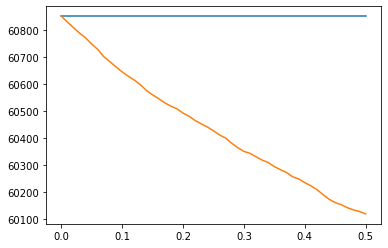

In [346]:
plt.plot(np.linspace(0,0.5,num=51), olds)
plt.plot(np.linspace(0,0.5,num=51), news)
plt.show()

For n = 1.5:


<Figure size 432x288 with 0 Axes>

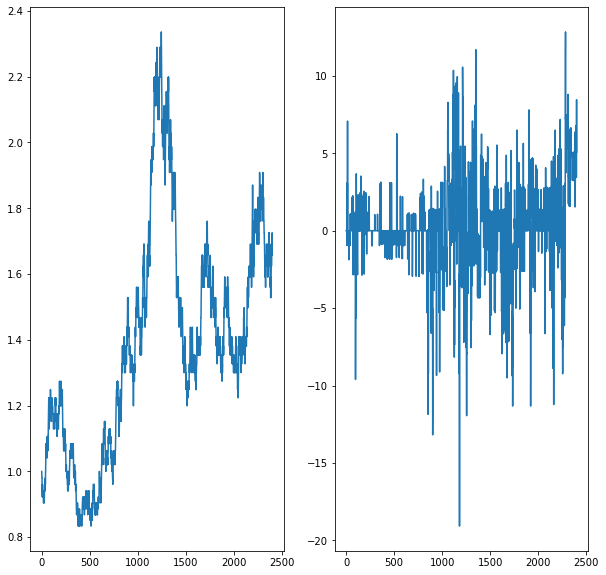

Net gain: 679.6725196659099


In [303]:
print('For n = 1.5:')

x_plot = list(range(2400))

_ = plt.tight_layout()

_ , axs = plt.subplots(1,2,figsize=(10,10))

#plt.subplot(1,2,1)
_ = axs[0].plot(x_plot, p)

#plt.subplot(1,2,2)
_ = axs[1].plot(x_plot, [c[i] - b[i] for i in x_plot])
#axs[1].scatter(x_plot, b, s=2)

_ = plt.show()

print(f'Net gain: {sum([c[i] - b[i] for i in x_plot])}')

For n = 1.05:


<Figure size 432x288 with 0 Axes>

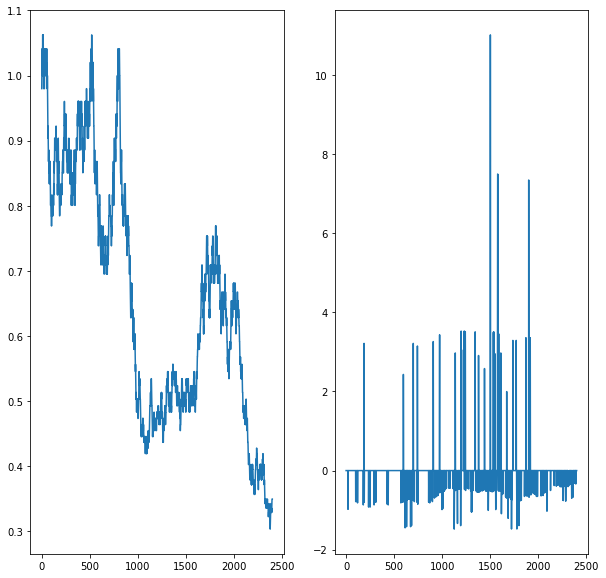

Net gain: -36.31902021901624


In [283]:
print('For n = 1.05:')

x_plot = list(range(2400))

plt.tight_layout()

_ , axs = plt.subplots(1,2,figsize=(10,10))

#plt.subplot(1,2,1)
_ = axs[0].plot(x_plot, p)

#plt.subplot(1,2,2)
_ = axs[1].plot(x_plot, [c[i] - b[i] for i in x_plot])
#axs[1].scatter(x_plot, b, s=2)

plt.show()

print(f'Net gain: {sum([c[i] - b[i] for i in x_plot])}')

For n = 1.01:


<Figure size 432x288 with 0 Axes>

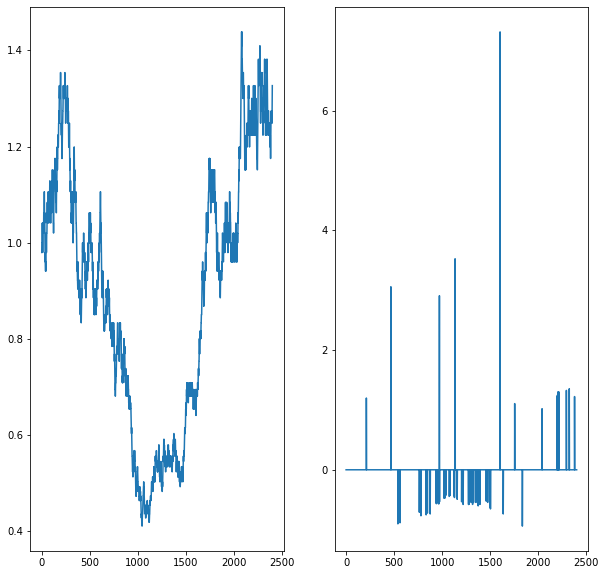

Net gain: 5.0950505015061935


In [286]:
print('For n = 1.01:')

x_plot = list(range(2400))

_ = plt.tight_layout()

_ , axs = plt.subplots(1,2,figsize=(10,10))

#plt.subplot(1,2,1)
_ = axs[0].plot(x_plot, p)

#plt.subplot(1,2,2)
_ = axs[1].plot(x_plot, [c[i] - b[i] for i in x_plot])
#axs[1].scatter(x_plot, b, s=2)

_ = plt.show()

print(f'Net gain: {sum([c[i] - b[i] for i in x_plot])}')

For n = 0.99:


<Figure size 432x288 with 0 Axes>

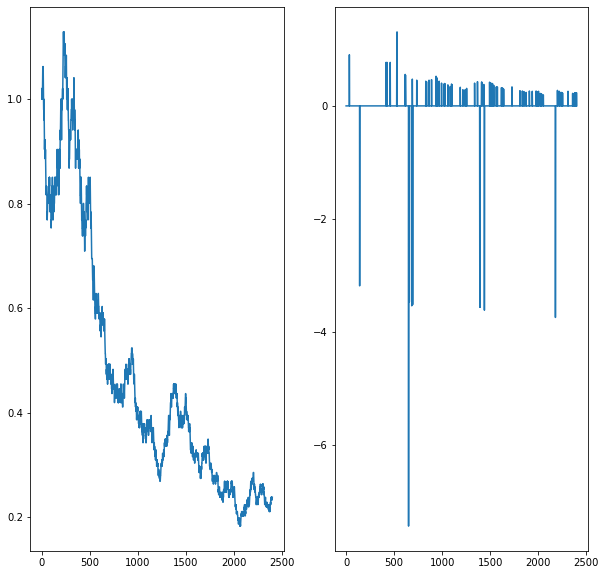

Net gain: -11.535773899682681


In [294]:
print('For n = 0.99:')

x_plot = list(range(2400))

plt.tight_layout()

_ , axs = plt.subplots(1,2,figsize=(10,10))

#plt.subplot(1,2,1)
_ = axs[0].plot(x_plot, p)

#plt.subplot(1,2,2)
_ = axs[1].plot(x_plot, [c[i] - b[i] for i in x_plot])
#axs[1].scatter(x_plot, b, s=2)

plt.show()

print(f'Net gain: {sum([c[i] - b[i] for i in x_plot])}')

For n = 0.95:


<Figure size 432x288 with 0 Axes>

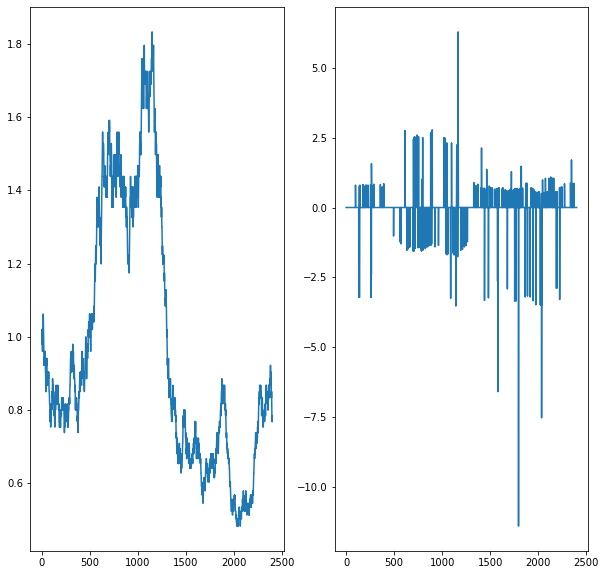

Net gain: 32.59725656532828


In [297]:
print('For n = 0.95:')

x_plot = list(range(2400))

plt.tight_layout()

_ , axs = plt.subplots(1,2,figsize=(10,10))

#plt.subplot(1,2,1)
_ = axs[0].plot(x_plot, p)

#plt.subplot(1,2,2)
_ = axs[1].plot(x_plot, [c[i] - b[i] for i in x_plot])
#axs[1].scatter(x_plot, b, s=2)

plt.show()

print(f'Net gain: {sum([c[i] - b[i] for i in x_plot])}')

For n = 0.67:


<Figure size 432x288 with 0 Axes>

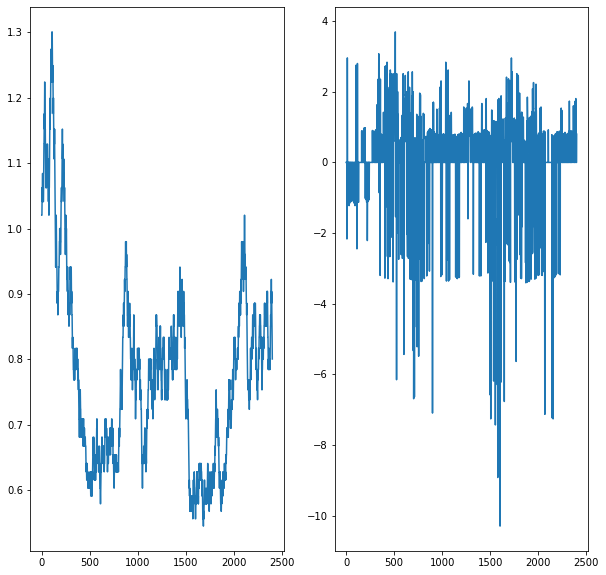

Net gain: 168.93236033472203


In [300]:
print('For n = 0.67:')

x_plot = list(range(2400))

plt.tight_layout()

_ , axs = plt.subplots(1,2,figsize=(10,10))

#plt.subplot(1,2,1)
_ = axs[0].plot(x_plot, p)

#plt.subplot(1,2,2)
_ = axs[1].plot(x_plot, [c[i] - b[i] for i in x_plot])
#axs[1].scatter(x_plot, b, s=2)

plt.show()

print(f'Net gain: {sum([c[i] - b[i] for i in x_plot])}')